

#                          项目 : Medical Treatment

本节课进一步学习Python简介和机器学习的流程。

我们下面将以一个医学项目作为例子，从头到尾带领大家学一下机器学习的流程，着重带领大家学习一下一个完整的机器学习项目的过程。

***准备工作***：
1. 整体快速浏览一下代码Outline
2. 在问题描述部分 下载数据
3. 安装环境
4. 将代码和数据文件放在同一个文件夹下面

下面，我们开始！

# 问题描述

在过去的几年中，关于精准医学，尤其是基因检测将如何改变癌症等疾病治疗方式的讨论已经很多。

然而，这一变革目前仅部分实现，因为仍然需要大量的手动工作。一旦完成测序，一个癌症肿瘤可能会包含数千种基因突变。但真正的挑战在于区分哪些突变是促进肿瘤生长的驱动因素（drivers），哪些是中性的突变（passengers）。

目前，这种对基因突变的解读是手动完成的。这是一项非常耗时的任务，临床病理学家需要根据基于文本的临床文献证据，手动审查和分类每一个基因突变。
因此，需要开发一种机器学习算法，利用这些知识库作为基准，自动对基因变异进行分类。

这个问题曾在 Kaggle 上发布为竞赛，奖金为 15,000 美元。该竞赛由纪念斯隆-凯特琳癌症中心（MSKCC）发起，并被 NIPS 2017 竞赛赛道接受，因为希望借助大家的力量，充分发挥个性化医学的潜力。

可以通过以下链接查看竞赛的所有详细信息：
https://www.kaggle.com/c/msk-redefining-cancer-treatment

为了获取数据集，请在 Kaggle 上创建一个登录账户，并访问上述问题页面，下载两个数据集：

***training_variants.zip*** 和 ***training_text.zip***


## 分析问题描述

首先，需要了解提供的数据集，并利用该数据集尝试理解机器学习领域中的上述问题。由于数据集非常庞大，可以使用 Python 来加载它。

In [1]:
# Loading all required packages
# If any of it fails, do not panic. Just install it using "pip3 install <package_name>" or by using conda install package_name
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from PIL import Image

这个问题有两个数据文件。训练时数据文件和代码文件放在**同一个文件夹**里。

#### 采用pandas加载CSV文件并查看数据

In [ ]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training_variants')
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [66]:
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


<p>
    先来看上面的数据，有四列: <br>
    <ul>
        <li><b>ID : </b>用于将突变与临床证据关联的唯一识别码</li>
        <li><b>Gene : </b>此基因突变所在的基因位置</li>
        <li><b>Variation : </b>此突变引起的氨基酸变化 </li>
        <li><b>Class :</b> 类别值1-9，表示此基因突变的分类标签</li>
    </ul>
    
再进一步简单分析以上数据

In [67]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [68]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [69]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [70]:
# Clecking column in above data set
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [71]:
object_columns = data_variants.select_dtypes(include=['object'])
object_columns.columns

Index(['Gene', 'Variation'], dtype='object')

下面来看看data_text里的数据

In [72]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


上面的数据有两列，ID和Text。可以观察到ID列在上面两个数据上是共用的。继续进一步探索数据。

In [73]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [74]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [75]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [76]:
# checking the dimentions
data_text.shape

(3321, 2)

因此，简单概括数据特征如下：
 * data_variants (ID, Gene, Variations, Class)
 * data_text(ID, text)

好的，现在已经了解了数据集。尝试从机器学习的角度来理解同一个问题。

我们想要预测癌症的类别。现在的问题是，类别列中存在什么样的数据。

In [77]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

这是离散数据，因此这是一个**分类问题**，由于存在多个离散的输出可能，我们可以称之为**多类别分类问题**。

### 什么是多分类？

将数据点分类为指定的类或类别是机器学习的基本任务之一。多类分类通过处理**两个以上的类别**来扩展二元分类的概念。


|               | **二分类**                                                                 | **多类分类**                                                                 |
|--------------------------|-----------------------------------------------------------------------------|------------------------------------------------------------------------------|
| **数据集特点**           | 涉及只有两个类实例的数据集。                                                 | 涉及具有多个类标签的数据集。                                                 |
| **分类器模型数量**       | 只需要一个分类器模型。                                                       | 分类器模型的数量取决于所选的分类技术：<br> - 一对全：如果 N 类实例，则 N 个二元分类器模型。<br> - 一对一：如果 N 类实例，则 N * (N-1)/2 个二元分类器模型。 |
| **混淆矩阵**             | 易于推导和理解。                                                             | 相对复杂，但可以扩展为多类混淆矩阵。                                         |
| **示例**                 | 在二元分类问题中，预测动物是 Dog 还是 Cat。                            | 多类分类问题可能涉及将动物分类为 Dog、Cat、Snake 等类别。                     |



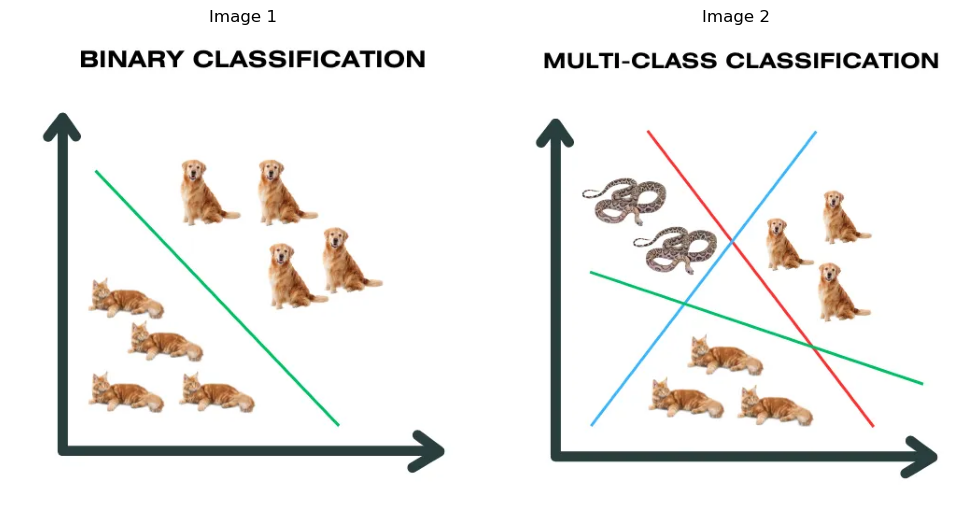

In [78]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# 加载两张 WebP 图片
image1 = Image.open('binaryclass.webp')
image2 = Image.open('multiclass.webp')

# 创建一个包含两个子图的图形
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 行 2 列的子图布局

# 在第一个子图中显示第一张图片
axes[0].imshow(image1)
axes[0].axis('off')  # 关闭坐标轴
axes[0].set_title('Image 1')  # 设置标题

# 在第二个子图中显示第二张图片
axes[1].imshow(image2)
axes[1].axis('off')  # 关闭坐标轴
axes[1].set_title('Image 2')  # 设置标题

# 调整子图间距
plt.tight_layout()

# 显示图形
plt.show()

实现多类分类的技术

1. One vs. Rest
2. One vs. One

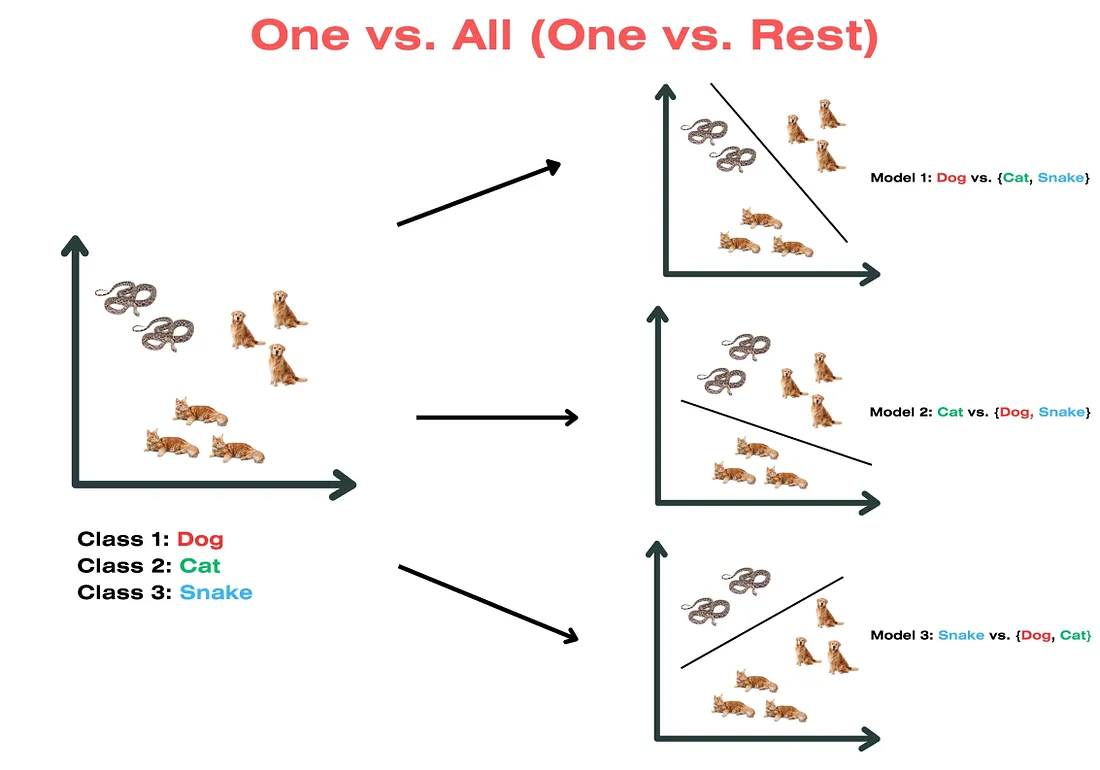

In [79]:
from IPython.display import Image as IPImage
IPImage(filename='onevsrest.webp')

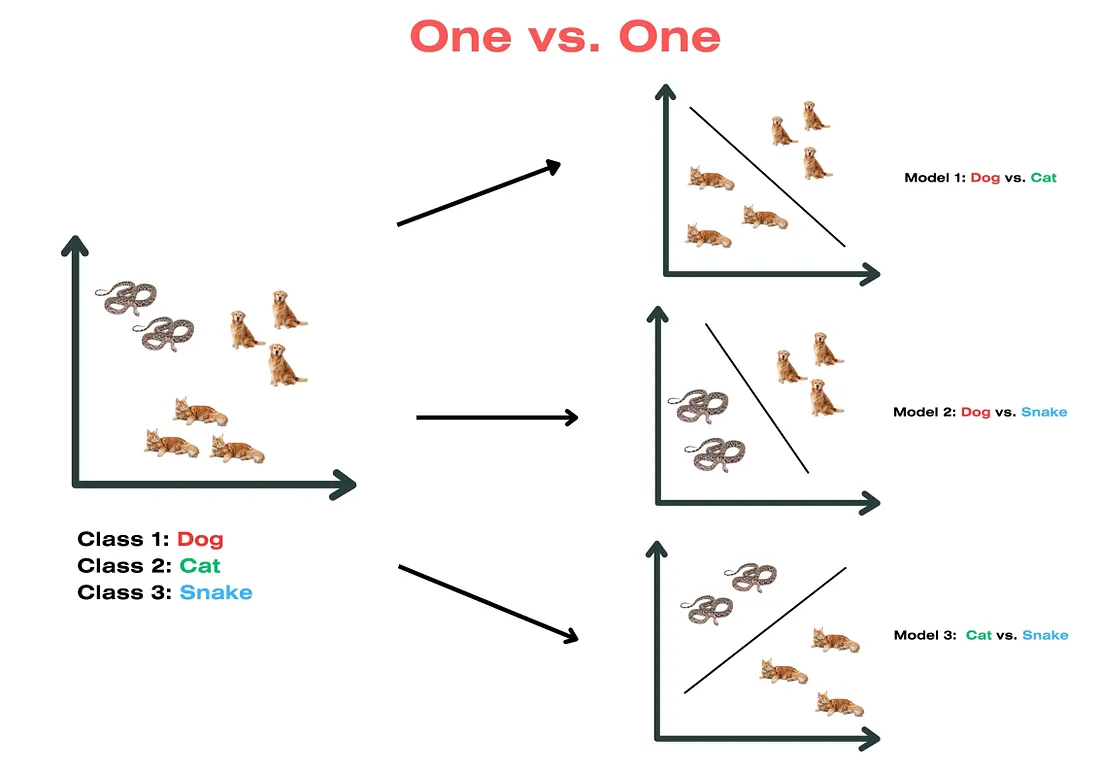

In [80]:
from IPython.display import Image as IPImage
IPImage(filename='onevsone.webp')

***重要提示***：这是一个与医学相关的问题，因此正确的结果非常重要。错误在这里可能会带来巨大的代价，因此希望以概率的形式获得每个类别的结果。只要机器学习算法花费的时间在合理范围内，我们不会过多关注耗时。

还希望我们的模型具有高度可解释性，因为医疗从业者希望能够给出合理的解释，说明为什么机器学习算法会预测某个类别。

下面将使用混淆矩阵和多类别对数损失来评估模型。

好的，现在已经理解了问题的陈述。让我们着手解决这个问题。

***注意***：强烈建议你先尝试自己解决问题。之后再回来参考我们的解决方案。

目前有大量的文本数据，因此需要对其进行预处理。为此需要编写一个函数。这个函数包括以下步骤：

1. 检查输入是否为字符串
2. 移除特殊字符
3. 标准化空白格
4. 转换为小写字母
5. 移除stop word（冠词、Be动词等
6. 更新dataframe

In [81]:
# We would like to remove all stop words like a, is, an, the, ... 
# so we collecting all of them from nltk library
# import nltk
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [82]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

### 采用 re.sub 对字符串进行替换操作
 
 Python 的 re.sub() 函数来对字符串进行替换操作。re.sub() 是正则表达式模块 re 中的一个方法，用于在字符串中查找匹配正则表达式的部分，并将其替换为指定的内容。
 
 下面详细说明这两行代码的用法和作用：
 1. **替换特殊字符为空格**\
    正则表达式 **[^a-zA-Z0-9\n]**：\
    **[^...]** 表示匹配不包含在括号内的任何字符。\
    **a-zA-Z** 匹配所有大小写字母。\
    **0-9** 匹配所有数字。\
    **\n** 匹配换行符。\
    因此，**[^a-zA-Z0-9\n]** 匹配所有非字母、非数字、非换行符的字符。\
    **' '**：    将匹配到的字符替换为一个空格。\
    **str(total_text)**：\
    确保 total_text 是字符串类型，避免因输入类型不匹配而报错。


 2. **将多个连续空格替换为单个空格**\
   正则表达式 **\s+**：\
   **\s** 匹配任何空白字符（包括空格、制表符 \t、换行符 \n 等）。\
   **+** 表示匹配前面的模式一次或多次。\
   因此，**\s+** 匹配一个或多个连续的空白字符。\
   ' '：
   将匹配到的连续空白字符替换为一个空格。

In [83]:
total_text = "Hello, 123! How are you?\n"
total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
print(total_text)  # 输出: "Hello  123  How are you \n"

Hello  123  How are you 



In [84]:
total_text = "Hello    world!\nHow are   you?"
total_text = re.sub('\s+', ' ', total_text)
print(total_text)  # 输出: "Hello world! How are you?"

Hello world! How are you?


下面我们继续

In [85]:
# Below code will take some time because its huge text (took 4 minute on my 16 GB RAM system), so run it and have a cup of coffee :)
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')


然后，我们需要合并两个数据。

### 采用pandas的merge合并数据

采用ID列作为共有列，合并两个数据表

In [86]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


**重要**：查看缺失值，否则这些缺失值会对最后的分析结果造成问题。

In [87]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


可以看到许多行数据存在缺失值。现在的问题是，如何处理这些缺失值。

一种方法是**删除包含缺失值的行**，或者我们可以对其进行某种**填补**。

我们选择进行填补。但问题是要填补什么：

我们可以尝试合并 **Gene** 和 **Variation** 列，作为**TEXT**列的填充。

In [88]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

再次检查一下是否存在任何缺失值。

In [89]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


太好了，现在没有缺失值了。

# 创建训练、测试和验证数据集

在将数据划分为训练集、测试集和验证集之前，我们需要确保将 **Gene**和 **Variation**列中的所有空格替换为下划线 _

In [90]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

下面开始数据集划分，分为训练、测试和验证数据集。

In [91]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [92]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


下面来看一下三个数据集中数据的分布情况。

In [93]:
# 按索引排序
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

# 或者按值排序
# train_class_distribution = train_df['Class'].value_counts().sort_values()
# test_class_distribution = test_df['Class'].value_counts().sort_values()
# cv_class_distribution = cv_df['Class'].value_counts().sort_values()

In [94]:
train_class_distribution

Class
1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: count, dtype: int64


那么，上述变量向我们传递了什么信息呢？这意味着在训练数据集中，类别1的值的数量为363，类别2的值的数量为289，以此类推。通过图表形式来可视化这些数据分布会是一个更好的方式。

***可视化训练集的类别分布***

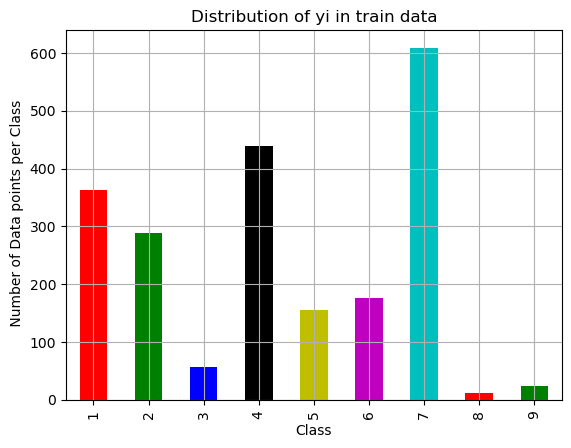

In [95]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar',color=list(my_colors))
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

来看看基于百分比的分布

In [96]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


来看看测试集的分布情况

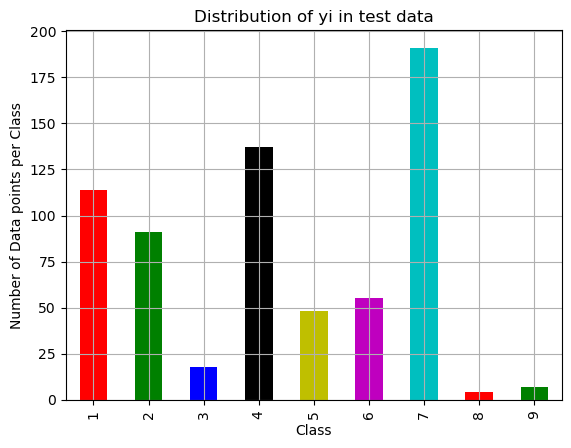

In [97]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar',color=list(my_colors))
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [98]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)



再来看看验证集的分布情况

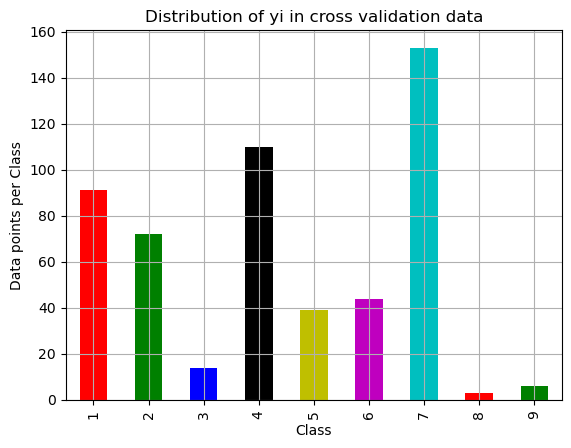

In [99]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar',color=list(my_colors))
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [100]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


## 为什么划分数据集？
在机器学习中，划分数据集是为了评估模型的性能，确保模型能够泛化到未见过的数据。

**训练模型：**
使用训练集（Training Set）来训练模型，学习数据中的模式和规律。\
**验证模型：**
使用验证集（Validation Set）来调整模型的超参数，防止过拟合。\
**测试模型：**
使用测试集（Test Set）来评估模型的最终性能，确保模型在未见过的数据上表现良好。\
**避免过拟合：**
通过将数据划分为训练集、验证集和测试集，可以避免模型在训练数据上过拟合，从而提高泛化能力。

---

现在的问题是，因为我们需要将对数损失（log-loss）作为最终的评估指标，那么我们如何确定将要构建的模型是一个好模型呢？\
为此，我们将构建一个随机模型并评估其对数损失。我们的模型应该返回比这个值更低的对数损失。

## **什么是 Log-Loss？**
Log-Loss（对数损失）是用于评估分类模型性能的一种损失函数，特别适用于概率输出的模型。它衡量的是模型预测的概率分布与真实标签分布之间的差异。Log-Loss 的值越小，表示模型的预测越准确。


对于多类别分类问题，Log-Loss 的公式如下：

$$
\text{Log-Loss} = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^C y_{ij} \cdot \log(p_{ij})
$$

其中

- $N$：样本数量。
- $C$：类别数量。
- $y_{ij}$：第 $i$ 个样本是否属于第 $j$个类别（1 表示是，0 表示否）。
- $p_{ij}$：模型预测第 $i$ 个样本属于第 $j$个类别的概率。

**Log-Loss 的意义**
1. 衡量概率预测的准确性\
    Log-Loss 直接评估模型预测的概率分布与真实标签的匹配程度。它不仅关注预测是否正确，还关注预测概率的置信度。例如：

    如果模型对某个样本的预测概率为 0.9，而真实标签确实是该类别，则 Log-Loss 会很小。
    如果模型对某个样本的预测概率为 0.1，而真实标签确实是该类别，则 Log-Loss 会很大。
2. 对错误预测的惩罚更严格\
    Log-Loss 对低置信度的正确预测和高置信度的错误预测都会施加较大的惩罚。例如：

    如果模型对某个样本的预测概率为 0.01，而真实标签确实是该类别，则 Log-Loss 会非常大。
    如果模型对某个样本的预测概率为 0.99，而真实标签不是该类别，则 Log-Loss 也会非常大。
3. 适用于多类别分类问题\
    Log-Loss 可以自然地扩展到多类别分类问题。它通过计算每个类别的概率分布与真实标签的对数误差，综合评估模型在所有类别上的表现。

4. 与模型优化目标一致\
    许多分类模型（如逻辑回归、神经网络）的优化目标是最大化对数似然函数，而 Log-Loss 是对数似然函数的负值。因此，最小化 Log-Loss 等价于最大化对数似然函数，与模型的优化目标一致。

**Log-Loss 计算示例**

假设有一个 3 类别分类问题，模型对某个样本的预测概率和真实标签如下：

| 类别     | 预测概率 | 真实标签 |
|----------|----------|----------|
| Class_1  | 0.7      | 1        |
| Class_2  | 0.2      | 0        |
| Class_3  | 0.1      | 0        |

**Log-Loss 计算**

Log-Loss 的公式为：

$$
\text{Log-Loss} = -\left(1 \cdot \log(0.7) + 0 \cdot \log(0.2) + 0 \cdot \log(0.1)\right)
$$

代入数值：

$$
\text{Log-Loss} = -\log(0.7) \approx 0.3567
$$

因此，该样本的 Log-Loss 为 **0.3567**。

# 构建随机模型
即随机生成标签。

我们需要生成 9 个随机数，因为我们有 9 个类别，且它们的和必须等于 1，因为所有 9 个类别的概率之和必须等于 1。

In [101]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [102]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y))

Log loss on Cross Validation Data using Random Model 2.432170975434444


In [103]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y))


Log loss on Test Data using Random Model 2.4544487670146338


In [104]:
# Lets get the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

In [105]:
# Lets see the output. these will be 665 values present in test dataset
predicted_y

array([3, 4, 2, 3, 5, 5, 0, 1, 1, 3, 2, 0, 6, 0, 6, 2, 8, 0, 5, 5, 0, 2,
       6, 1, 5, 3, 5, 7, 6, 5, 8, 5, 6, 8, 1, 6, 4, 1, 4, 0, 2, 1, 7, 5,
       6, 2, 0, 6, 7, 1, 8, 8, 2, 8, 8, 3, 7, 1, 2, 8, 4, 2, 5, 0, 1, 3,
       2, 4, 2, 4, 0, 1, 8, 4, 4, 2, 1, 8, 2, 1, 1, 2, 5, 0, 6, 5, 0, 3,
       7, 5, 7, 4, 1, 7, 1, 6, 2, 6, 1, 8, 0, 6, 7, 1, 4, 6, 6, 8, 4, 4,
       4, 1, 2, 7, 5, 5, 7, 0, 0, 0, 7, 5, 8, 0, 3, 4, 3, 8, 8, 5, 5, 4,
       7, 8, 1, 7, 2, 1, 8, 1, 5, 5, 8, 3, 7, 1, 2, 5, 5, 6, 5, 2, 5, 1,
       6, 3, 6, 6, 1, 2, 2, 3, 6, 0, 0, 5, 3, 2, 2, 0, 2, 8, 3, 6, 0, 4,
       2, 5, 3, 0, 3, 1, 0, 6, 4, 0, 8, 0, 0, 1, 6, 6, 3, 5, 7, 0, 6, 1,
       6, 6, 1, 2, 0, 4, 5, 2, 8, 3, 2, 3, 7, 1, 8, 0, 4, 5, 0, 7, 0, 5,
       2, 7, 8, 8, 8, 0, 7, 5, 0, 4, 7, 6, 0, 4, 1, 0, 2, 8, 2, 7, 0, 7,
       5, 3, 0, 7, 7, 5, 0, 6, 8, 3, 8, 5, 6, 3, 1, 8, 5, 0, 0, 2, 7, 3,
       4, 0, 2, 7, 0, 2, 2, 3, 0, 3, 7, 0, 2, 5, 3, 0, 1, 6, 7, 8, 8, 1,
       7, 1, 1, 1, 8, 1, 3, 3, 1, 3, 8, 7, 1, 2, 8,

所以可以看到索引值的范围是从 0 到 8。那么，让我们将其改为从 1 到 9，我们将这些值都增加 1。方便可视化。

In [106]:
predicted_y = predicted_y + 1

## 有哪些评估指标？
本项目主要采用三种评估方法：
1. 混淆矩阵
2. 精度矩阵
3. 召回矩阵



 **混淆矩阵（Confusion Matrix）**

混淆矩阵用于展示分类模型的预测结果与真实标签的对比情况。对于二分类问题，混淆矩阵的结构如下：

|                     | **预测为正类** | **预测为负类** |
|---------------------|----------------|----------------|
| **实际为正类**      | 真正例 (TP)    | 假负例 (FN)    |
| **实际为负类**      | 假正例 (FP)    | 真负例 (TN)    |

- **真正例 (True Positive, TP)**：模型正确预测为正类的样本。
- **假正例 (False Positive, FP)**：模型错误预测为正类的样本（实际为负类）。
- **真负例 (True Negative, TN)**：模型正确预测为负类的样本。
- **假负例 (False Negative, FN)**：模型错误预测为负类的样本（实际为正类）。

---

**精度（Precision）**

精度衡量的是模型预测为正类的样本中有多少是真正的正类。公式如下：

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

---

**召回率（Recall）**

召回率衡量的是实际为正类的样本中有多少被模型正确预测为正类。公式如下：

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

---

**F1 分数（F1 Score）**

F1 分数是精度和召回率的调和平均值，用于平衡两者之间的关系。公式如下：

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

 **示例**

假设有一个二分类问题，混淆矩阵如下：

|                     | **预测为正类** | **预测为负类** |
|---------------------|----------------|----------------|
| **实际为正类**      | 80             | 20             |
| **实际为负类**      | 30             | 70             |

计算精度和召回率：
- **精度**：
 $$
  \text{Precision} = \frac{80}{80 + 30} = \frac{80}{110} \approx 0.727
 $$
- **召回率**：
 $$
  \text{Recall} = \frac{80}{80 + 20} = \frac{80}{100} = 0.8
 $$
- **F1 分数**：
  $$
  F1 = 2 \cdot \frac{0.727 \cdot 0.8}{0.727 + 0.8} \approx 0.761
  $$

**思考**：

多分类的混淆矩阵是什么样的？如何利用混淆矩阵计算精度和召回矩阵？

### 混淆矩阵 (Confusion Matrix)

In [107]:
C = confusion_matrix(y_test, predicted_y)

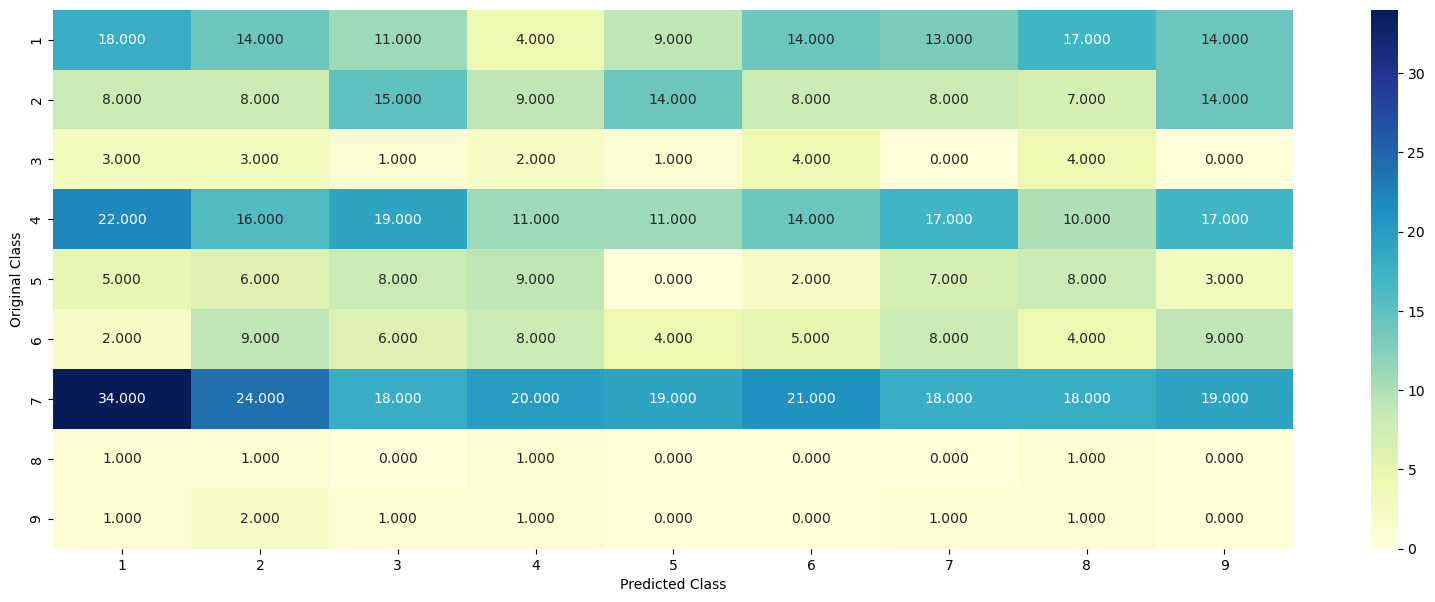

In [108]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### 精度矩阵

In [109]:
B =(C/C.sum(axis=0))  # 每列求和

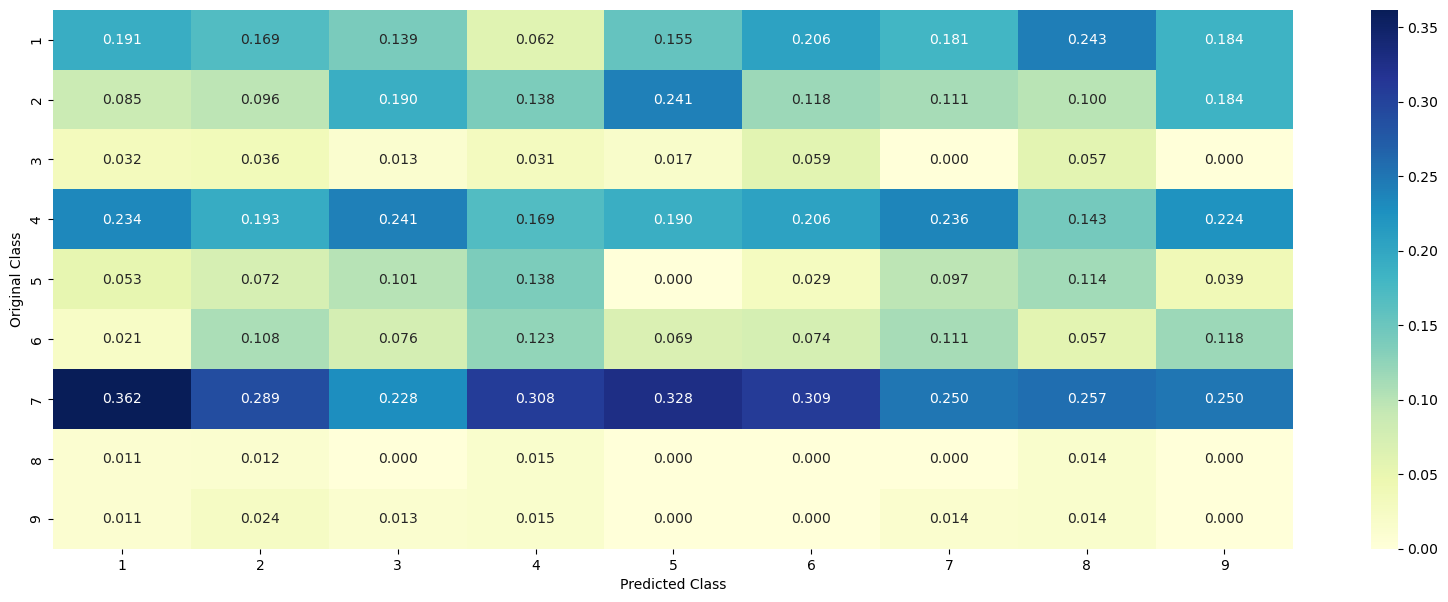

In [110]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### 召回矩阵

In [111]:
A =(((C.T)/(C.sum(axis=1))).T)

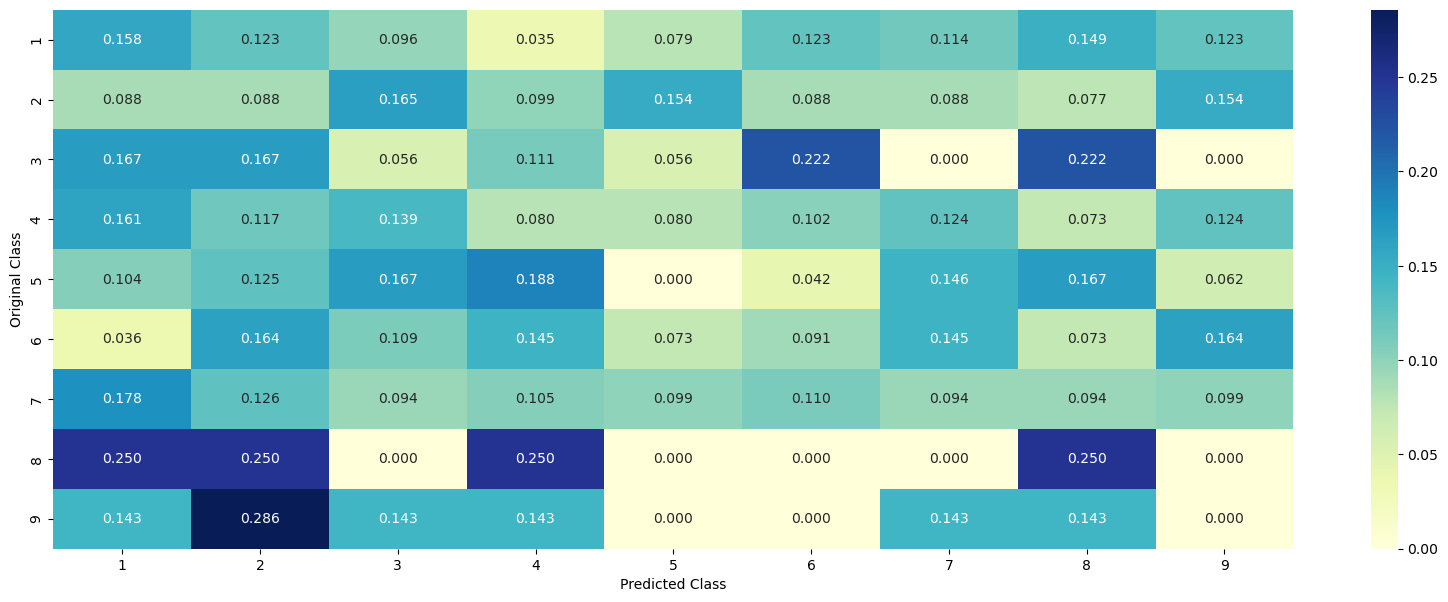

In [112]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# 评估 Gene 列

现在，我们将逐一查看每个独立的列，以确保它们与我的目标变量相关。但问题是，如何做到这一点？

以第一个列 Gene 为例来理解，它是一个分类性质的列。

因此，我们先探索 **Gene** 列，并查看其分布情况。

In [113]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 227
Gene
BRCA1     176
TP53      101
EGFR       86
BRCA2      79
PTEN       74
KIT        68
BRAF       65
ERBB2      43
ALK        41
PDGFRA     39
Name: count, dtype: int64


我们看看基因列中存在的唯一值的数量。

In [114]:
unique_genes.shape[0]

227

让我们来看一下唯一基因值的累积分布

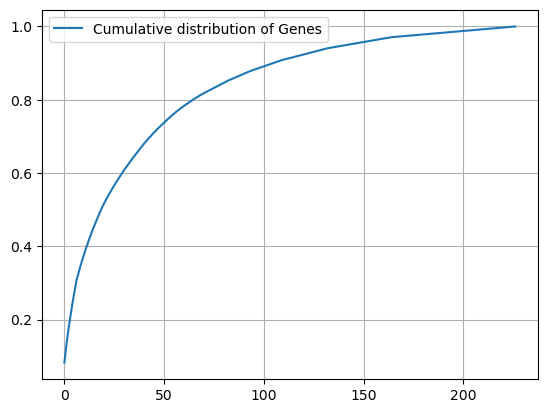

In [115]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

因此，现在我们需要将这些分类变量转换为合适的格式，以便机器学习算法能够将其作为输入。

我们有两种处理技术：

<ol>
    <li> 独热编码(One-hot encoding) </li>
    <li> 响应编码(Response Encoding) or (均值填补，Mean imputation) </li>
</ol>



### **什么是独热编码？**

1. 将分类变量的每个类别转换为一个二进制向量。如果分类变量有 C 个类别，则生成 C 个二进制列，每列表示一个类别是否出现。
2. 优点：避免了类别之间的数值大小关系，适合无序分类变量。适用于线性模型（如线性回归、逻辑回归）和基于距离的模型（如 KNN）。
3. 缺点：当类别数量很多时，会导致特征维度爆炸。增加了计算复杂度和内存消耗。
4. 应用场景：类别数量较少且无序的分类变量。

**Note**：和Label Encoding的区别
1. LE定义：将分类变量的每个类别映射为一个整数。例如，Red -> 0, Green -> 1, Blue -> 2
2. 缺点：引入了类别之间的数值大小关系，可能会误导模型（例如，0 < 1 < 2 可能被模型误解为 Red < Green < Blue）。
3. 应用场景：类别之间有序的分类变量（如 Low, Medium, High）。

### **什么是响应编码？**

Response Encoding（响应编码）是一种特征编码技术，用于将**分类变量**（如 Gene 或 Variation）转换为**数值特征**。核心思想是通过计算每个类别在目标变量中的条件概率（或某种统计量）来生成新的特征。具体来说，对于每个类别值，我们计算它在每个目标类别中的出现概率或相关统计量。例如，在分类问题中，可以计算某个类别值在每个类别中的频率，并将这些频率作为新的特征。其作用是捕捉类别与目标变量的关系和减少维度：Response Encoding 能够捕捉**分类变量**与**目标变量**之间的关系，生成的数值特征可以直接用于机器学习模型。


    相比于独热编码（One-Hot Encoding），Response Encoding 生成的维度更低，因为它为每个目标类别生成一个向量，而不是为每个特征类别生成一个单独的列。

    
- Laplace Smoothing的作用：
    Laplace Smoothing（拉普拉斯平滑）是一种用于处理概率估计的技术，特别是在统计中出现零概率的情况下。它的核心思想是为每个类别添加一个小的常数（通常为 1 或某个值 α），以避免概率为零的情况。在 Response Encoding 中，Laplace Smoothing 用于计算条件概率。公式如下：
    $$
    P(y = c \mid x = v) = \frac{\text{count}(x = v, y = c) + \alpha}{\text{count}(x = v) + C \cdot \alpha}
    $$    
    其中 ,\
    $P(y = c \mid x = v)$：在特征值 v 的条件下，目标类别 c 的条件概率。\
    $\text{count}(x = v, y = c) $：特征值 v 在目标类别 c 中出现的次数。\
    $\text{count}(x = v) $：特征值 v 在整个数据集中出现的次数。\
    $\alpha $：平滑参数（通常为 1）。\
    $ C $：目标类别的总数。
- 优点：生成的维度较低（等于目标类别数），避免了维度爆炸。捕捉了分类变量与目标变量之间的关系。
- 缺点：需要依赖目标变量的分布信息，可能会引入数据泄漏问题。

让我们同时使用这两种方法，看看哪一种效果最好。现在，我们从独热编码开始。

In [116]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

让我们检查一下经过独热编码后生成的列数。独热编码总是会返回更多的列数。

In [117]:
train_gene_feature_onehotCoding.shape

(2124, 226)

In [118]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1b', 'arid2', 'atm', 'atrx', 'aurka', 'aurkb',
       'axin1', 'axl', 'b2m', 'bap1', 'bcl10', 'bcl2', 'bcor', 'braf',
       'brca1', 'brca2', 'brip1', 'btk', 'card11', 'carm1', 'casp8',
       'cbl', 'ccnd1', 'ccnd3', 'ccne1', 'cdh1', 'cdk12', 'cdk4', 'cdk6',
       'cdk8', 'cdkn1a', 'cdkn1b', 'cdkn2a', 'cdkn2b', 'cdkn2c', 'chek2',
       'cic', 'crebbp', 'ctcf', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a',
       'dnmt3b', 'egfr', 'eif1ax', 'elf3', 'ep300', 'epas1', 'epcam',
       'erbb2', 'erbb3', 'erbb4', 'ercc2', 'ercc3', 'ercc4', 'erg',
       'esr1', 'etv1', 'etv6', 'ewsr1', 'ezh2', 'fanca', 'fat1', 'fbxw7',
       'fgf19', 'fgf3', 'fgf4', 'fgfr1', 'fgfr2', 'fgfr3', 'flt1', 'flt3',
       'foxa1', 'foxl2', 'foxo1', 'foxp1', 'fubp1', 'gata3', 'gnaq',
       'gnas', 'h3f3a', 'hist1h1c', 'hla', 'hnf1a', 'hras', 'idh1',
       'idh2', 'igf1r', 'ikzf1', 'il7r', 'inpp4b', 'jak1', 'jak2', 'jun',
 

#### 使用pandas的get_dummies来进行独热编码

In [119]:
pd_onehotcoding = pd.get_dummies(train_df['Gene'], columns=object_columns)  # 独热编码
print(pd_onehotcoding.shape)
pd_onehotcoding.head(5)

(2124, 227)


,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,AR,ARAF,...,TP53,TP53BP1,TSC1,TSC2,U2AF1,VEGFA,VHL,WHSC1,XPO1,YAP1
2539,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
787,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1671,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3007,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1110,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


接下来，我们为 Gene 列创建响应编码列。

In [120]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [121]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

让我们看看应用响应编码后的列。响应编码后，Gene 列应该有 9 列。

In [122]:
print(train_gene_feature_responseCoding.shape)
train_gene_feature_responseCoding[:5,:]

(2124, 9)


array([[0.18421053, 0.03759398, 0.07518797, 0.16165414, 0.2556391 ,
        0.17293233, 0.03759398, 0.03759398, 0.03759398],
       [0.09345794, 0.10280374, 0.10280374, 0.09345794, 0.09345794,
        0.13084112, 0.19626168, 0.09345794, 0.09345794],
       [0.08      , 0.096     , 0.12      , 0.08      , 0.08      ,
        0.08      , 0.304     , 0.08      , 0.08      ],
       [0.06329114, 0.2721519 , 0.06962025, 0.06329114, 0.06329114,
        0.06962025, 0.2721519 , 0.06329114, 0.06329114],
       [0.13265306, 0.10204082, 0.10204082, 0.15306122, 0.10204082,
        0.10204082, 0.10204082, 0.10204082, 0.10204082]])

现在的问题是，Gene 列的特征在预测9个类别中有多好?

一个想法是，我们可以构建一个仅包含 Gene 列且使用独热编码的简单模型，例如逻辑回归。

如果仅使用 Gene 列的逻辑回归模型的 log-loss 结果优于随机模型，那么这个特征是重要的。

## **什么是SGD Classifier？**

https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/

In [123]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [124]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))


For values of alpha =  1e-05 The log loss is: 1.155549454255371
For values of alpha =  0.0001 The log loss is: 1.1334422372481296
For values of alpha =  0.001 The log loss is: 1.1752561101472878
For values of alpha =  0.01 The log loss is: 1.283336367068119
For values of alpha =  0.1 The log loss is: 1.3896418700140407
For values of alpha =  1 The log loss is: 1.4360621464445147


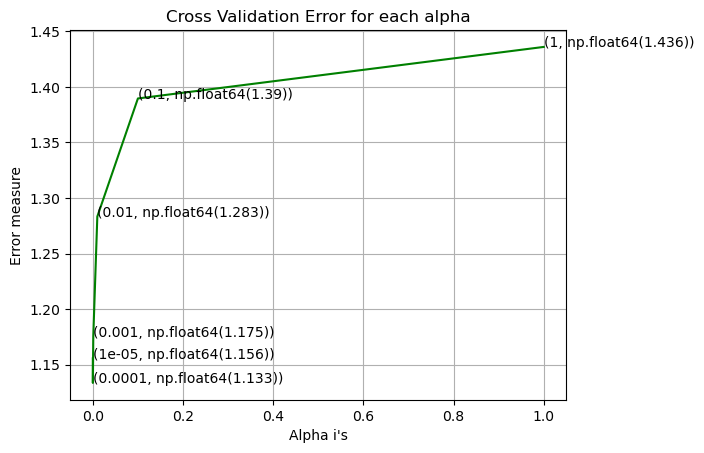

In [125]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [126]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


For values of best alpha =  0.0001 The train log loss is: 0.9967363848757839
For values of best alpha =  0.0001 The cross validation log loss is: 1.1334422372481296
For values of best alpha =  0.0001 The test log loss is: 1.2343109445609588


现在让我们检查一下训练集、测试集或交叉验证集与训练集之间有多少重叠的值。

In [127]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [128]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 636 out of 665 : 95.6390977443609
2. In cross validation data 515 out of  532 : 96.80451127819549


# 评估 Variation 列

**Variation（变异）** 也是一个分类变量，因此我们需要以与处理 **Gene** 列相同的方式来处理它。我们将再次为 Variation 列生成独热编码（One-Hot Encoding）和响应编码（Response Encoding）的特征。

In [129]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1931
Variation
Truncating Mutations    61
Deletion                47
Amplification           42
Fusions                 27
Overexpression           5
G12V                     3
EWSR1-ETV1 Fusion        2
T167A                    2
Q22K                     2
G12A                     2
Name: count, dtype: int64


让我们来看一下 variation 唯一值的累积分布

[0.0287194  0.05084746 0.07062147 ... 0.99905838 0.99952919 1.        ]


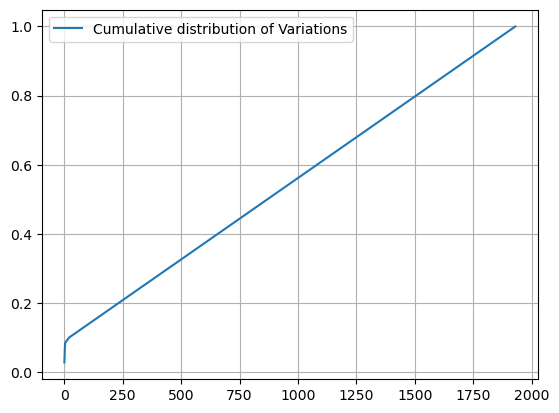

In [130]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

下面把variation列转换为独热编码

In [131]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

下面查看variation的独热编码列的维度

In [132]:
train_variation_feature_onehotCoding.shape

(2124, 1958)

下面同样为variation列生成响应编码

In [133]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

下面查看响应编码结果的维度

In [134]:
train_variation_feature_responseCoding.shape

(2124, 9)

同样地，下面仅适用variation列建立模型

In [135]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [136]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

For values of alpha =  1e-05 The log loss is: 1.709123752658546
For values of alpha =  0.0001 The log loss is: 1.7044727399320796
For values of alpha =  0.001 The log loss is: 1.7059732131011514
For values of alpha =  0.01 The log loss is: 1.7224806569632283
For values of alpha =  0.1 The log loss is: 1.737809120283655
For values of alpha =  1 The log loss is: 1.7364540606393706


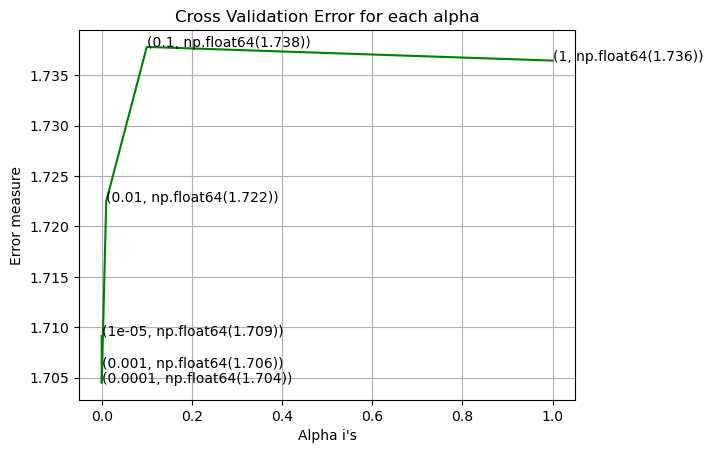

In [137]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [138]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.0001 The train log loss is: 0.6861295374897478
For values of best alpha =  0.0001 The cross validation log loss is: 1.7044727399320796
For values of best alpha =  0.0001 The test log loss is: 1.6863538971321081


In [139]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [140]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 70 out of 665 : 10.526315789473683
2. In cross validation data 54 out of  532 : 10.150375939849624


# 评估 Text 列

In [141]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [142]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [143]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53138


In [144]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [145]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [146]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [147]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [148]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [149]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({np.int64(3): 5457, np.int64(4): 3621, np.int64(6): 2700, np.int64(5): 2642, np.int64(8): 2338, np.int64(7): 2014, np.int64(9): 1735, np.int64(10): 1449, np.int64(12): 1371, np.int64(11): 1257, np.int64(13): 1147, np.int64(16): 850, np.int64(14): 817, np.int64(15): 733, np.int64(18): 687, np.int64(20): 673, np.int64(17): 560, np.int64(24): 519, np.int64(19): 491, np.int64(21): 481, np.int64(25): 448, np.int64(22): 422, np.int64(26): 417, np.int64(28): 394, np.int64(23): 358, np.int64(30): 356, np.int64(39): 339, np.int64(27): 322, np.int64(36): 317, np.int64(31): 306, np.int64(29): 289, np.int64(54): 279, np.int64(33): 269, np.int64(32): 260, np.int64(40): 253, np.int64(35): 245, np.int64(42): 237, np.int64(34): 227, np.int64(37): 202, np.int64(38): 200, np.int64(41): 194, np.int64(48): 173, np.int64(44): 172, np.int64(45): 171, np.int64(46): 163, np.int64(49): 161, np.int64(43): 161, np.int64(50): 153, np.int64(52): 151, np.int64(51): 148, np.int64(72): 146, np.int64(55): 141,

仅用 ***text*** 列建立模型

In [150]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))


For values of alpha =  1e-05 The log loss is: 1.2792577348171303
For values of alpha =  0.0001 The log loss is: 1.1162912029945944
For values of alpha =  0.001 The log loss is: 1.0944299075835509
For values of alpha =  0.01 The log loss is: 1.1770364304083396
For values of alpha =  0.1 The log loss is: 1.4158049278783131
For values of alpha =  1 The log loss is: 1.639367575412782


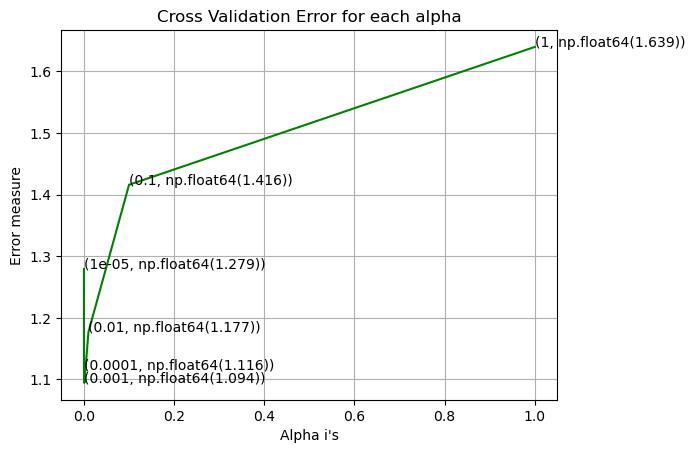

In [151]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [152]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


For values of best alpha =  0.001 The train log loss is: 0.6509660464972302
For values of best alpha =  0.001 The cross validation log loss is: 1.0944299075835509
For values of best alpha =  0.001 The test log loss is: 1.1852701129862644


检查text数据的重叠情况

In [155]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [156]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.551 % of word of test data appeared in train data
97.54 % of word of Cross Validation appeared in train data



所以，这三列(**Gene**, **Variation**, **TEXT**)都很重要。

# 为机器学习模型准备数据

下面创建一些会用到的函数。

In [115]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [116]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [131]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_count_vec.get_feature_names_out())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names_out()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names_out()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## 将以上3个特征堆叠在一起

### 使用hstack水平堆叠矩阵

 常用于将不同特征矩阵按列拼接，形成完整的特征集。也可以用于处理稀疏矩阵的水平拼接。

In [157]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [158]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55322)
(number of data points * number of features) in test data =  (665, 55322)
(number of data points * number of features) in cross validation data = (532, 55322)


In [159]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# 建立机器学习模型

让我们从第一个模型开始，这个模型最适合处理大量文本列数据。因此，我们将从朴素贝叶斯（Naive Bayes）模型开始。

## 朴素贝叶斯（Naive Bayes）

### 什么是朴素贝叶斯分类器？

**基本原理：**

$$
P(Y|X) = \frac{P(X|Y) \cdot P(Y)}{P(X)}
$$

其中：

- $P(Y∣X)$ 是后验概率，表示在给定特征 X 的情况下，类别 Y 的概率。
- $P(X∣Y)$ 是似然概率，表示在类别 Y 的情况下，特征 X 的概率。
- $P(Y)$ 是先验概率，表示类别 Y 的先验概率。
- $P(X)$ 是证据因子，表示特征 X 的概率。

Naive Bayes 通过计算**每个类别**的**后验概率**，并将样本分配给具有**最高后验概率**的类别来进行分类。

**MultinomialNB(alpha=i) 中的平滑公式**
平滑公式如下：

$$
P(x_i|y) = \frac{count(x_i, y) + \alpha}{count(y) + \alpha \cdot n}
$$

其中：

- $count(x_i ,y)$ 是特征 $x_i$ 在类别 y 中的出现次数。
- $count(y)$ 是类别 y 中所有特征的总出现次数。
- $n$ 是特征的总数。
- $α$ 是平滑参数。

In [121]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.3760068855904115
for alpha = 0.0001
Log Loss : 1.378590397526841
for alpha = 0.001
Log Loss : 1.3784231006929297
for alpha = 0.1
Log Loss : 1.3366610446387062
for alpha = 1
Log Loss : 1.338141461569925
for alpha = 10
Log Loss : 1.4205769636600296
for alpha = 100
Log Loss : 1.4170376161168623
for alpha = 1000
Log Loss : 1.3550783991897093


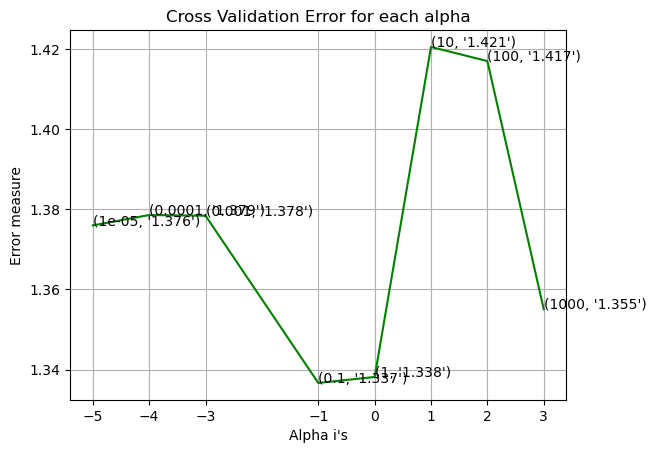

In [122]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [123]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


For values of best alpha =  0.1 The train log loss is: 0.8319465520619775
For values of best alpha =  0.1 The cross validation log loss is: 1.3366610446387062
For values of best alpha =  0.1 The test log loss is: 1.2856549043845185


采用最优alpha，在测试集上测试朴素贝叶斯

Log Loss : 1.3366610446387062
Number of missclassified point : 0.4323308270676692
-------------------- Confusion matrix --------------------


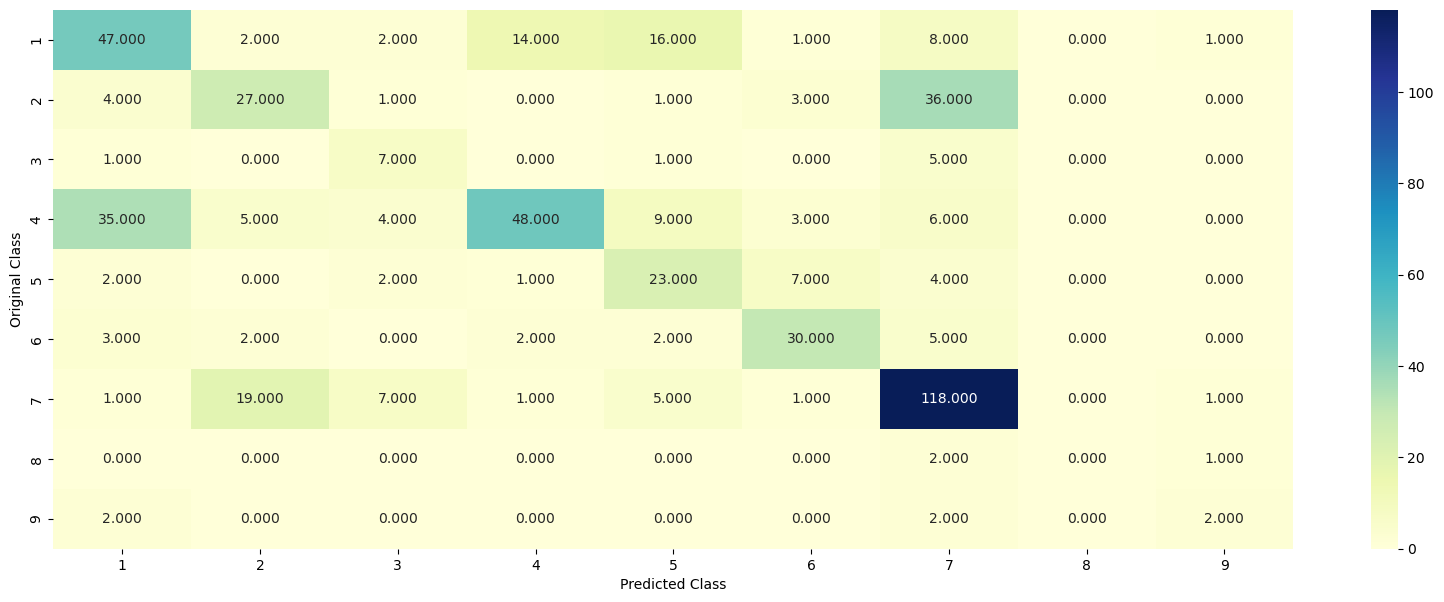

-------------------- Precision matrix (Columm Sum=1) --------------------


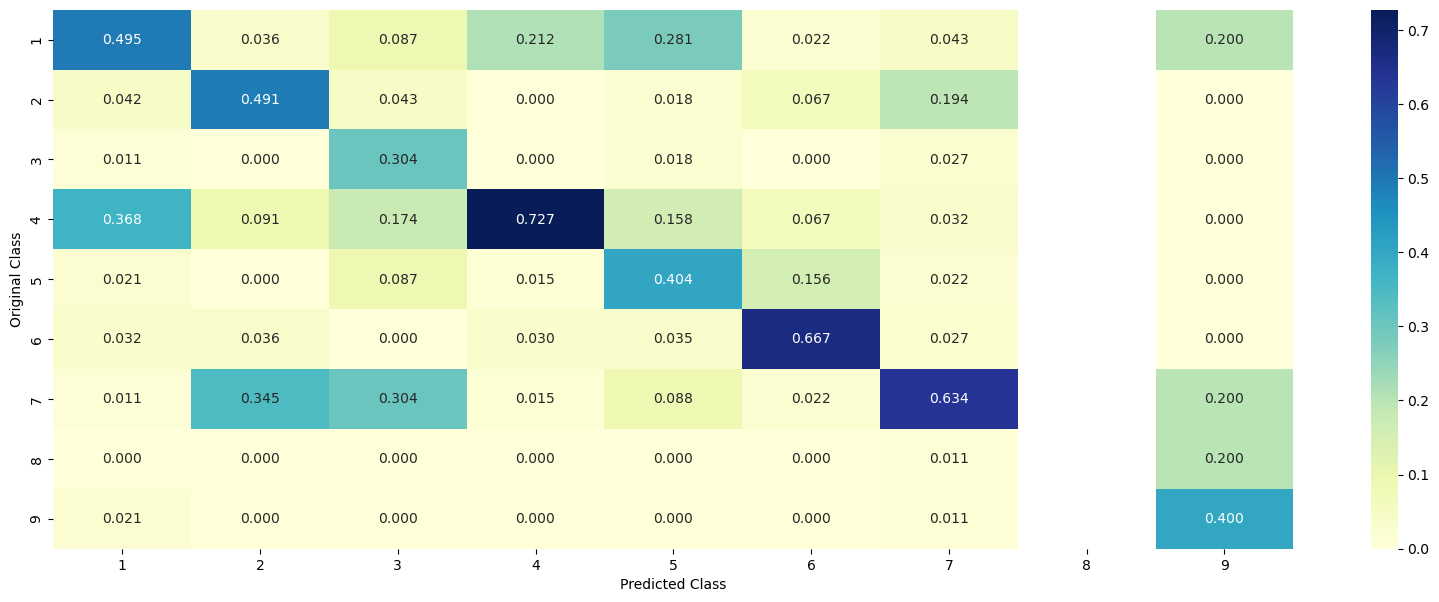

-------------------- Recall matrix (Row sum=1) --------------------


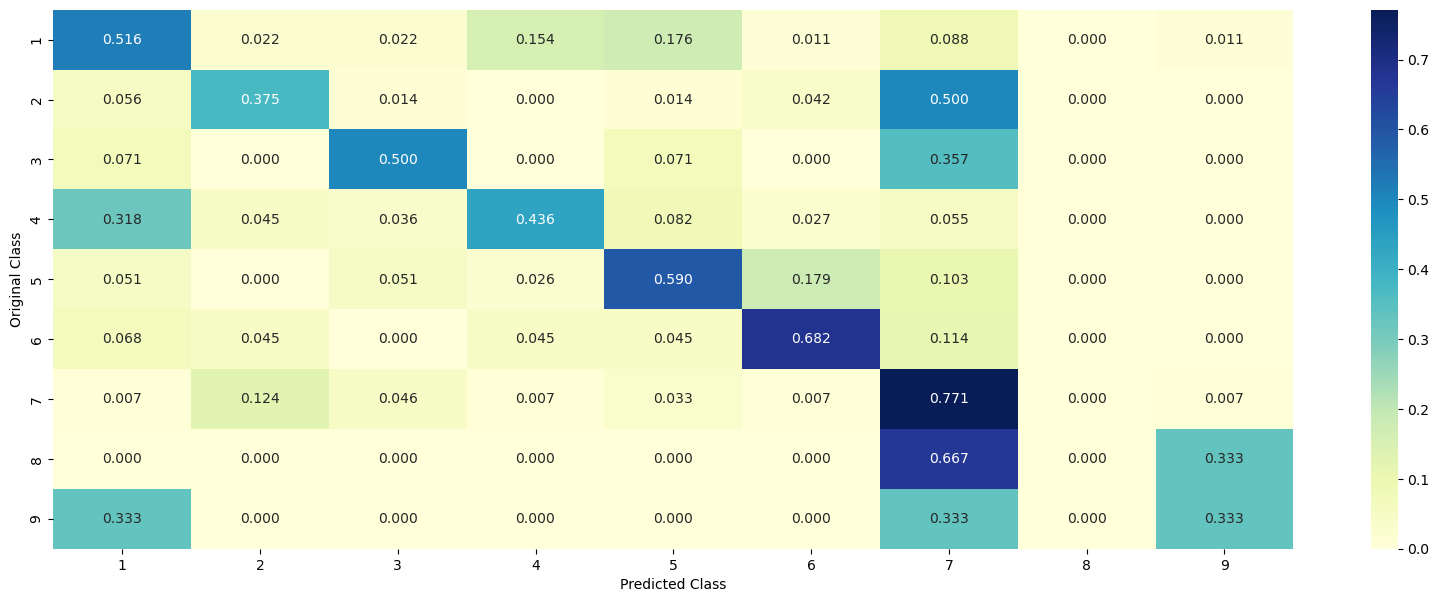

In [124]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### 查询样本与解释性


In [135]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.08   0.3708 0.0148 0.1129 0.0384 0.035  0.3416 0.0037 0.0029]]
Actual Class : 2
--------------------------------------------------
18 Text feature [identified] present in test data point [True]
19 Text feature [novel] present in test data point [True]
20 Text feature [sequencing] present in test data point [True]
21 Text feature [including] present in test data point [True]
22 Text feature [harbored] present in test data point [True]
23 Text feature [molecular] present in test data point [True]
28 Text feature [detection] present in test data point [True]
29 Text feature [clinical] present in test data point [True]
30 Text feature [harboring] present in test data point [True]
31 Text feature [present] present in test data point [True]
32 Text feature [patient] present in test data point [True]
33 Text feature [harbor] present in test data point [True]
35 Text feature [identify] present in test data point [True]
36 Text feature [new

再看看其他样本

In [133]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4444 0.0762 0.0151 0.251  0.0397 0.0366 0.13   0.0039 0.0031]]
Actual Class : 4
--------------------------------------------------
16 Text feature [function] present in test data point [True]
17 Text feature [type] present in test data point [True]
18 Text feature [affect] present in test data point [True]
19 Text feature [protein] present in test data point [True]
20 Text feature [one] present in test data point [True]
21 Text feature [wild] present in test data point [True]
22 Text feature [reduced] present in test data point [True]
23 Text feature [remaining] present in test data point [True]
24 Text feature [two] present in test data point [True]
25 Text feature [loss] present in test data point [True]
26 Text feature [amino] present in test data point [True]
27 Text feature [four] present in test data point [True]
28 Text feature [sequence] present in test data point [True]
29 Text feature [effect] present in test data point [

所以朴素贝叶斯表现一般，我们下面看看其他模型

## K 近邻分类（K Nearest Neighbour Classification）

### 什么是KNN？
K Nearest Neighbour (KNN) 是一种**有监督**学习算法，用于**分类和回归**任务。\
其核心思想是：相似的样本在特征空间中彼此靠近。KNN 通过计算待分类样本与训练集中所有样本的**距离**，找到距离最近的 k 个邻居，并根据这些邻居的类别来预测待分类样本的类别。

**算法步骤**
1. 选择邻居数量 k: 设定一个正整数 k，表示用于分类的最近邻居的数量。
2. 计算距离:对于待分类样本 x，计算它与训练集中每个样本 $x_i$ 的距离。常用的距离度量包括：

    欧氏距离(Euclidean Distance)
    $$
    d(x, x_i) = \sqrt{\sum_{j=1}^n (x_j - x_{i,j})^2}
    $$

    曼哈顿距离 (Manhattan Distance)
    $$
    d(x, x_i) = \sum_{j=1}^n |x_j - x_{i,j}|
    $$

3. 找到 k 个最近邻居：根据计算的距离，选择距离最近的 k 个样本作为邻居。
4. 投票决定类别：对于分类任务，统计 k 个邻居中每个类别的出现次数，将待分类样本分配给出现次数最多的类别。
5. 输出结果：返回待分类样本的预测类别。

**关键参数**
- k 值：k 是 KNN 的核心参数。较小的 k 值会使模型对噪声敏感，而较大的 k 值会使模型过于平滑。通常通过交叉验证来选择最优的 k 值。
- 距离度量：选择合适的距离度量方法（如欧氏距离、曼哈顿距离）对算法的性能有重要影响。
- 权重：可以为邻居的投票分配权重，例如根据距离的倒数，使得距离更近的邻居对分类结果有更大的影响。



In [136]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.1219428299275385
for alpha = 11
Log Loss : 1.090551764003032
for alpha = 15
Log Loss : 1.0985585048829833
for alpha = 21
Log Loss : 1.1032915697835552
for alpha = 31
Log Loss : 1.096249307917426
for alpha = 41
Log Loss : 1.0916760110996144
for alpha = 51
Log Loss : 1.1052272013072755
for alpha = 99
Log Loss : 1.1186838940128525


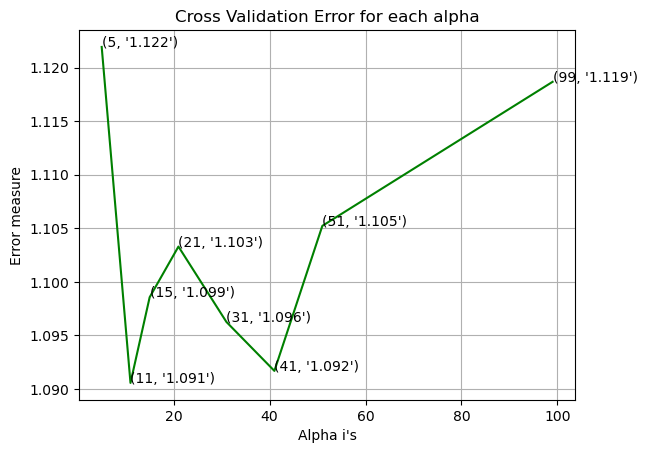

In [137]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [138]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


For values of best alpha =  11 The train log loss is: 0.6084071052951485
For values of best alpha =  11 The cross validation log loss is: 1.090551764003032
For values of best alpha =  11 The test log loss is: 1.082810388651137


在测试集上测试最优的alpha

Log loss : 1.090551764003032
Number of mis-classified points : 0.37218045112781956
-------------------- Confusion matrix --------------------


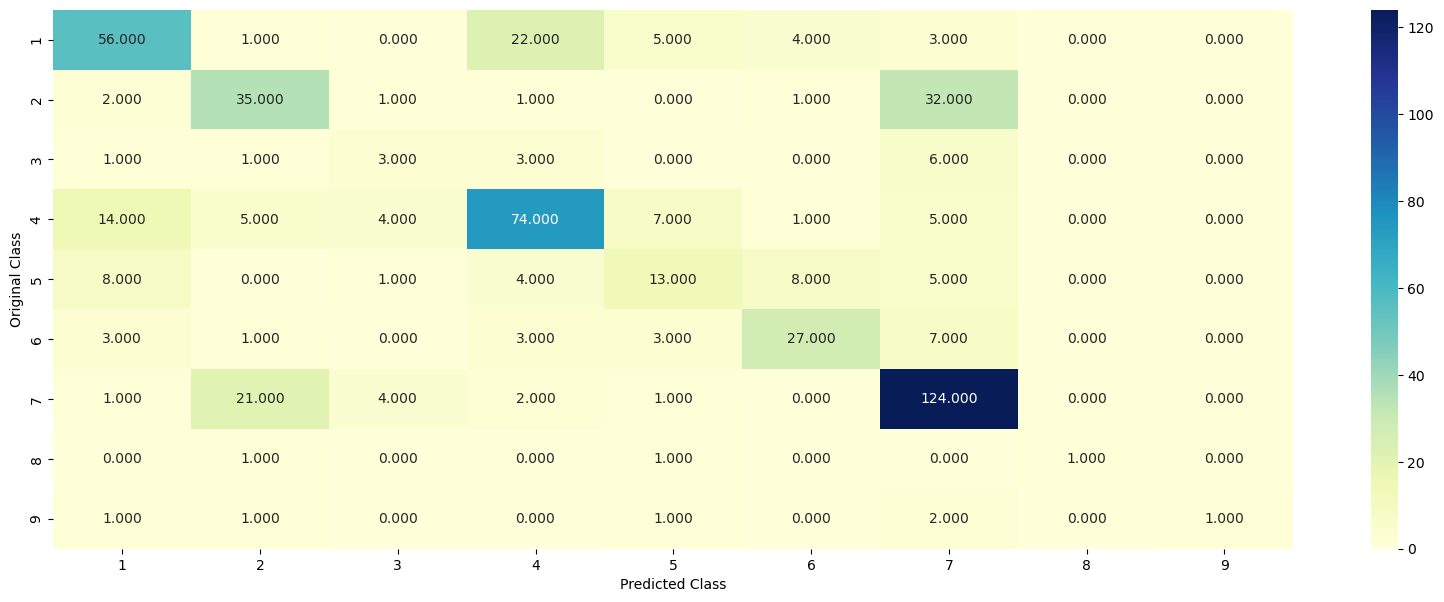

-------------------- Precision matrix (Columm Sum=1) --------------------


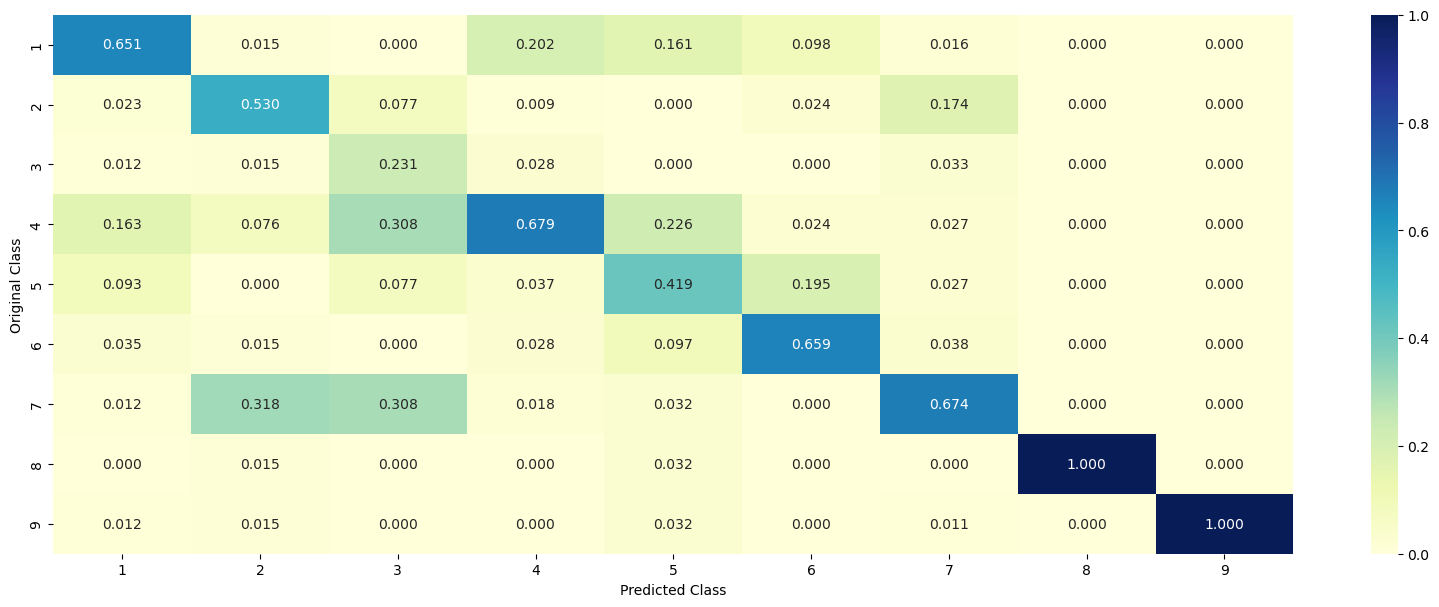

-------------------- Recall matrix (Row sum=1) --------------------


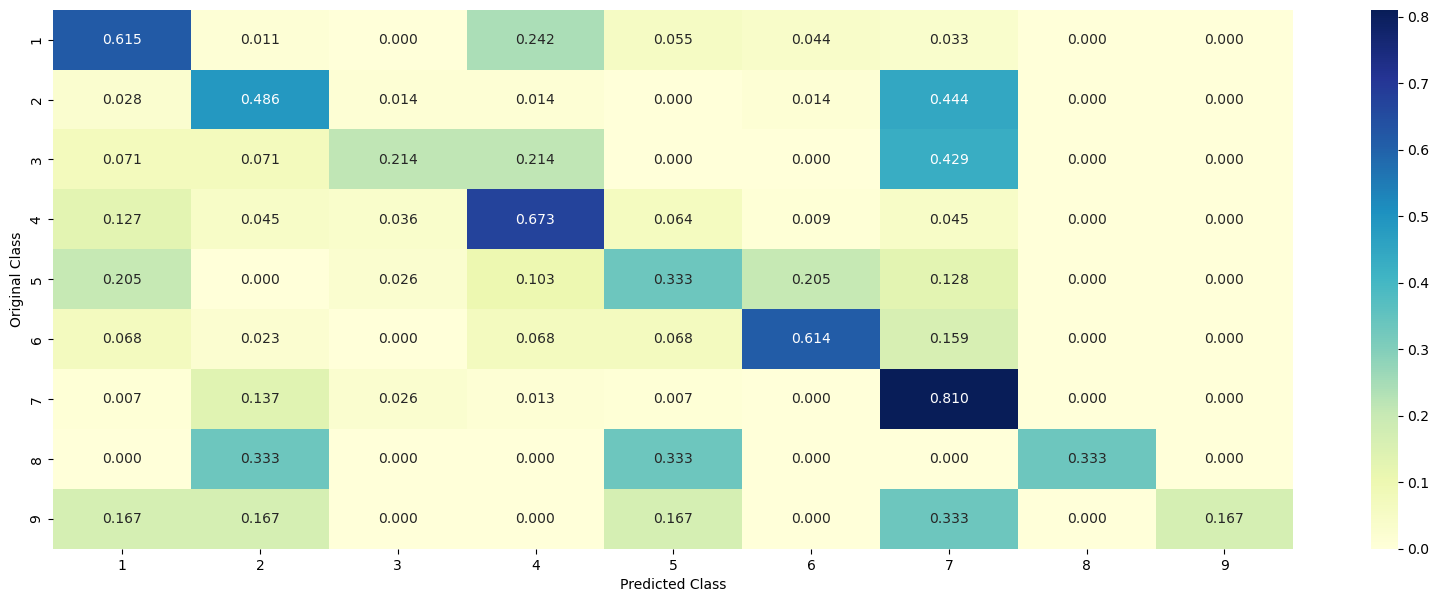

In [139]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [140]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 2
The  11  nearest neighbours of the test points belongs to classes [7 2 7 7 7 2 7 7 7 7 7]
Fequency of nearest points : Counter({np.int64(7): 9, np.int64(2): 2})


In [141]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [4 4 4 4 1 4 1 4 1 4 4]
Fequency of nearest points : Counter({np.int64(4): 8, np.int64(1): 3})


## 逻辑回归（Logistic Regression）

### 什么是数据平衡？

**数据平衡性** 是指数据集中各类别样本数量的分布是否均衡。在分类问题中，如果每个类别的样本数量大致相同，则称数据集是平衡的；反之，如果某些类别的样本数量远远多于其他类别，则称数据集是不平衡的。

**数据平衡性的意义**
1. **模型性能**
    在平衡数据上训练的模型通常能够对各类别进行公平的预测，整体性能较好。\
    在不平衡数据上训练的模型可能会对多数类过拟合，而对少数类的分类效果较差。\
    
2. **评估指标**\
    对于**平衡数据**，准确率（Accuracy） 是一个有效的评估指标。\
    对于**不平衡数据**，准确率可能会产生误导（例如，模型将所有样本预测为多数类，准确率仍然很高）。此时，需要使用其他指标，如 精确率（Precision）、召回率（Recall）、F1 分数（F1 Score） 或 ROC-PRC。

### 所有类别平衡

In [143]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.3847285024444944
for alpha = 1e-05
Log Loss : 1.3545900558661323
for alpha = 0.0001
Log Loss : 1.2075002699711486
for alpha = 0.001
Log Loss : 1.1662560024641748
for alpha = 0.01
Log Loss : 1.2069844150497007
for alpha = 0.1
Log Loss : 1.503987998511939
for alpha = 1
Log Loss : 1.7393594826690764
for alpha = 10
Log Loss : 1.7638930317406007
for alpha = 100
Log Loss : 1.7663591440681448


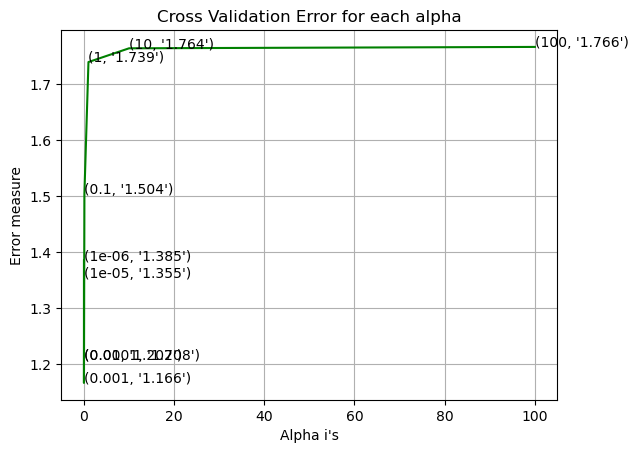

In [144]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [145]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.001 The train log loss is: 0.5138417625923769
For values of best alpha =  0.001 The cross validation log loss is: 1.1662560024641748
For values of best alpha =  0.001 The test log loss is: 1.1152200432238968


在测试集上测试最优alpha

Log loss : 1.1662560024641748
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


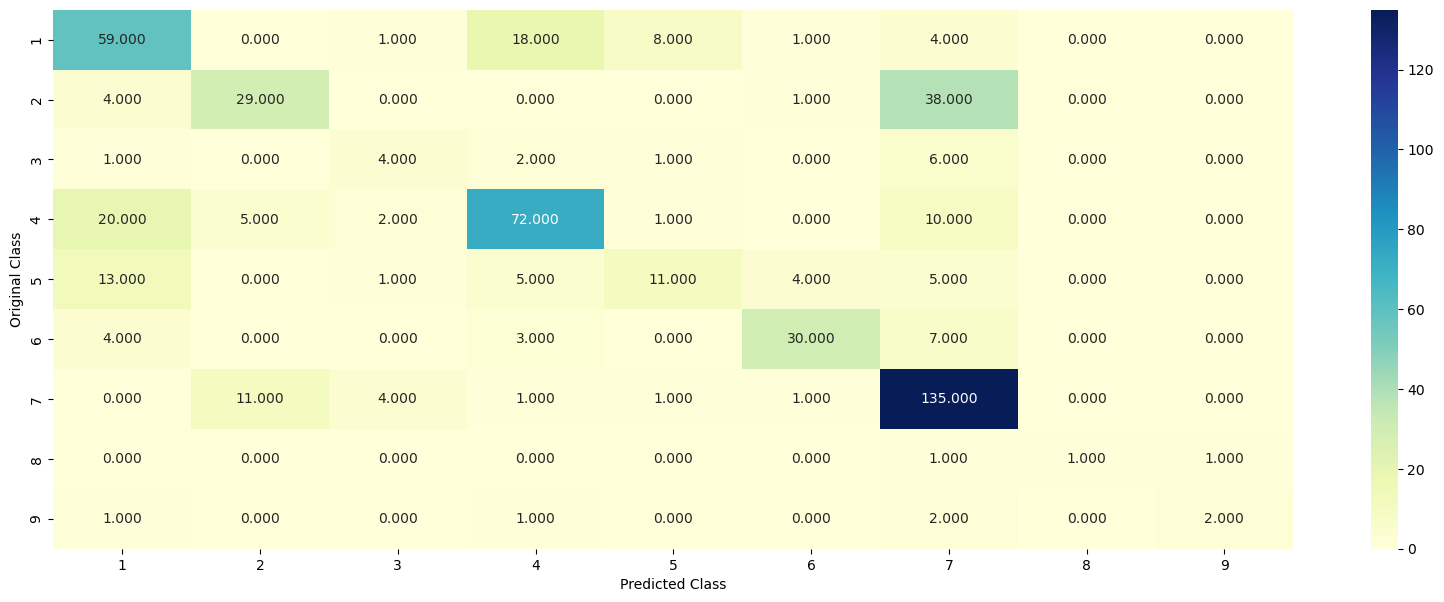

-------------------- Precision matrix (Columm Sum=1) --------------------


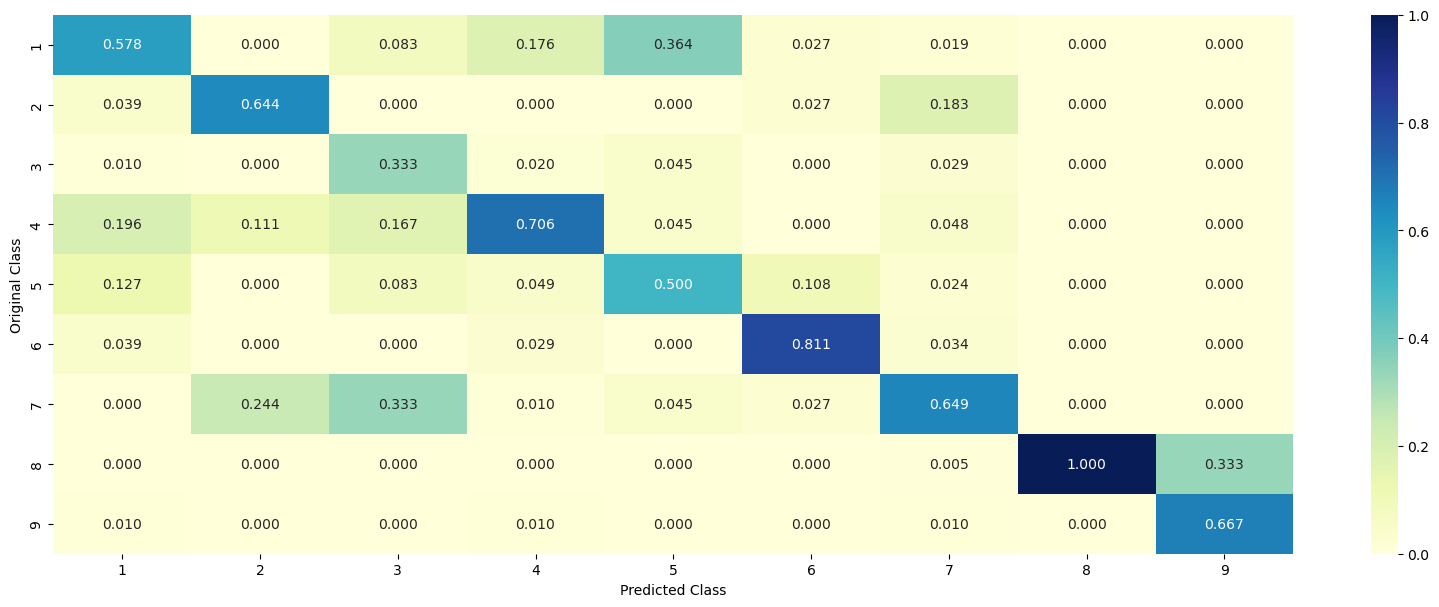

-------------------- Recall matrix (Row sum=1) --------------------


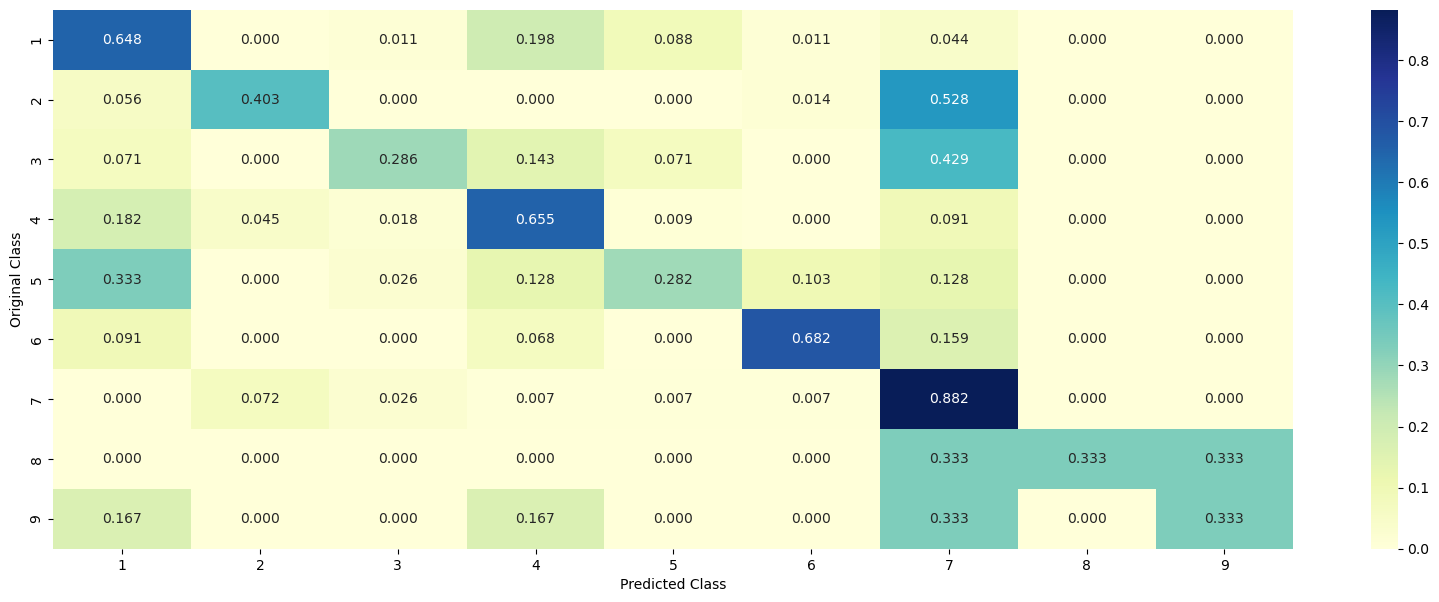

In [146]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### 特征重要性

In [147]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

测试查询点并进行可解释性分析

In [149]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[1.100e-03 4.998e-01 2.000e-04 1.300e-03 2.200e-03 1.800e-03 4.923e-01
  1.200e-03 1.000e-04]]
Actual Class : 2
--------------------------------------------------
190 Text feature [chemoradiotherapy] present in test data point [True]
212 Text feature [flaherty] present in test data point [True]
228 Text feature [discretion] present in test data point [True]
272 Text feature [ffpe] present in test data point [True]
331 Text feature [g466] present in test data point [True]
340 Text feature [wan] present in test data point [True]
388 Text feature [corporation] present in test data point [True]
436 Text feature [race] present in test data point [True]
453 Text feature [houben] present in test data point [True]
461 Text feature [demographic] present in test data point [True]
Out of the top  500  features  10 are present in query point


In [150]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.3708 0.0612 0.0146 0.4165 0.0412 0.0408 0.0425 0.0067 0.0057]]
Actual Class : 4
--------------------------------------------------
96 Text feature [acetylation] present in test data point [True]
275 Text feature [suppressor] present in test data point [True]
388 Text feature [defective] present in test data point [True]
Out of the top  500  features  3 are present in query point


### 所有类别不平衡

In [152]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for alpha = 1e-06
Log Loss : 1.3509305524083675
for alpha = 1e-05
Log Loss : 1.3563284396753688
for alpha = 0.0001
Log Loss : 1.2387674368510992
for alpha = 0.001
Log Loss : 1.1937202571010654
for alpha = 0.01
Log Loss : 1.2344201724922381
for alpha = 0.1
Log Loss : 1.3877456012394787
for alpha = 1
Log Loss : 1.627481092605225


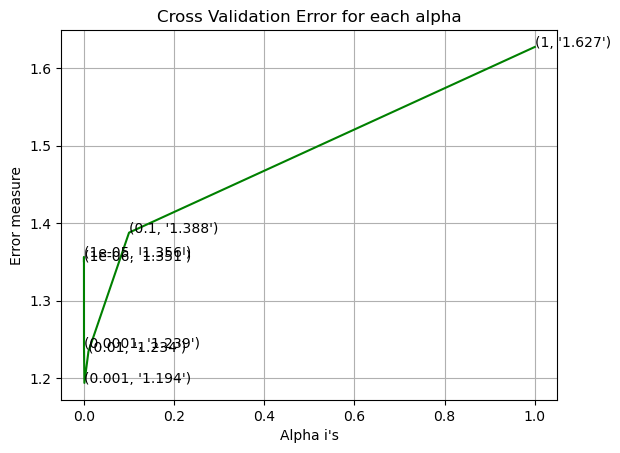

In [153]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [154]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.001 The train log loss is: 0.5079478863671022
For values of best alpha =  0.001 The cross validation log loss is: 1.1937202571010654
For values of best alpha =  0.001 The test log loss is: 1.1308042986932285


采用最优超参测试模型

Log loss : 1.1937202571010654
Number of mis-classified points : 0.35902255639097747
-------------------- Confusion matrix --------------------


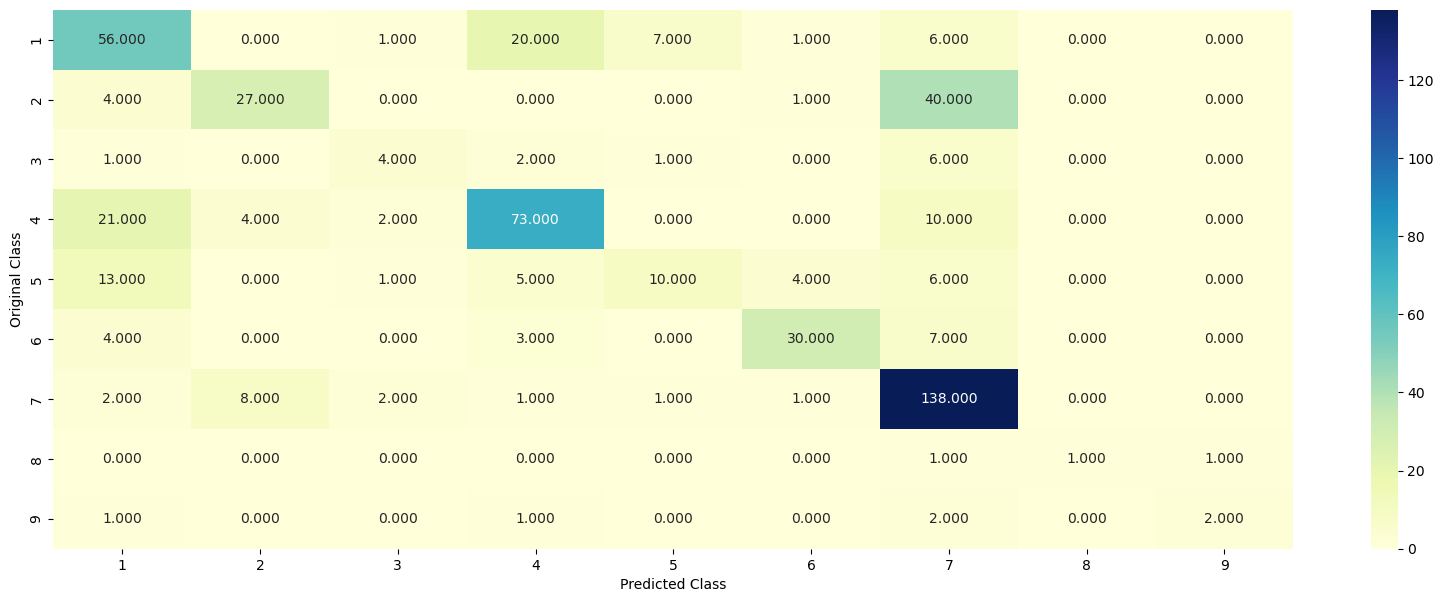

-------------------- Precision matrix (Columm Sum=1) --------------------


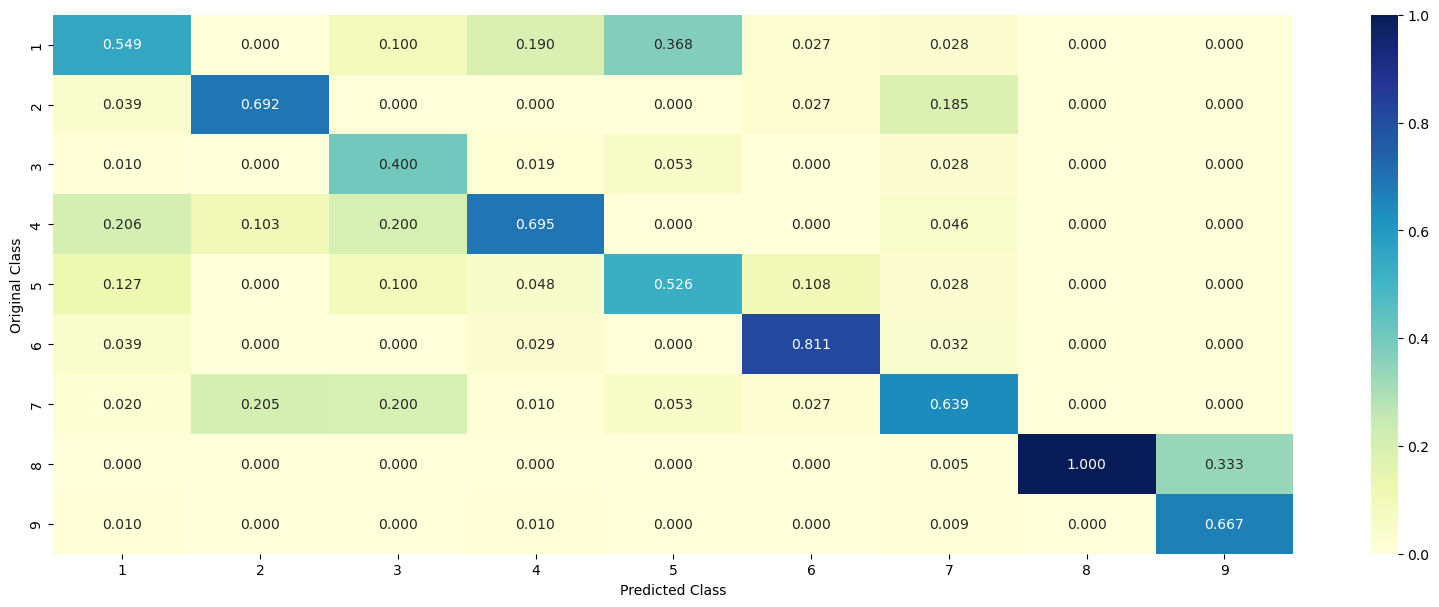

-------------------- Recall matrix (Row sum=1) --------------------


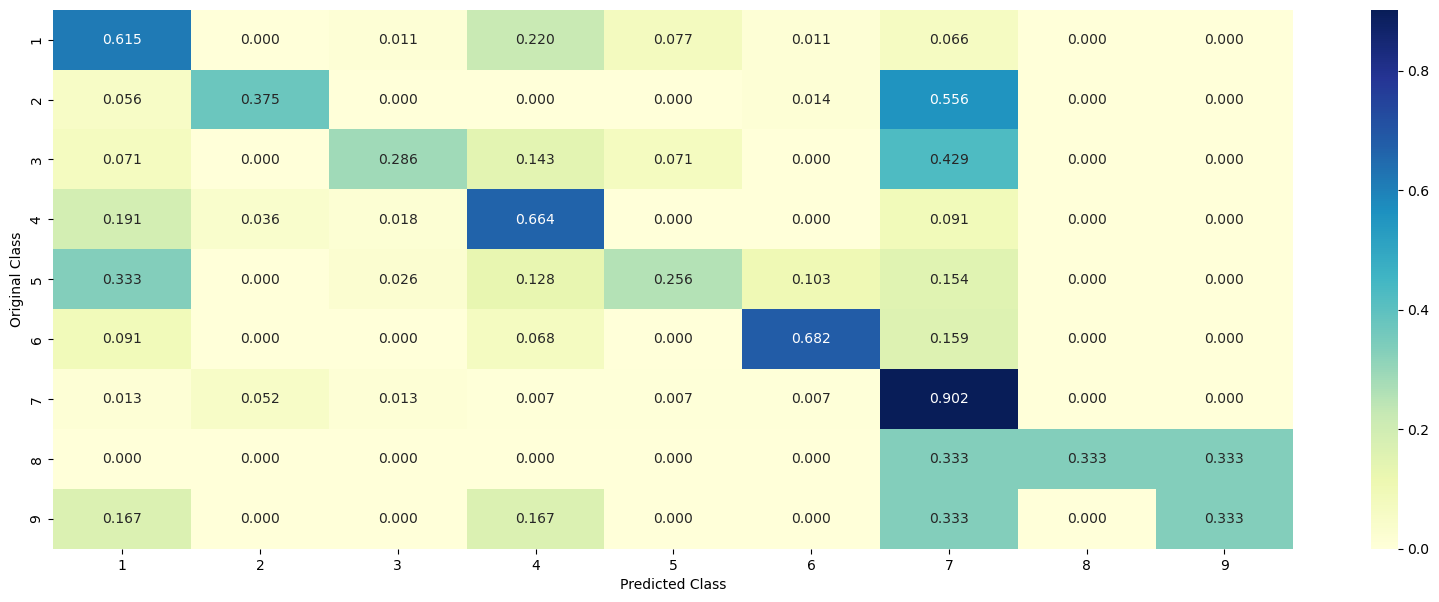

In [155]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### 查询点与解释性

In [156]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.100e-03 4.276e-01 1.000e-04 1.500e-03 1.300e-03 1.100e-03 5.671e-01
  2.000e-04 0.000e+00]]
Actual Class : 2
--------------------------------------------------
52 Text feature [constitutively] present in test data point [True]
71 Text feature [transforming] present in test data point [True]
86 Text feature [constitutive] present in test data point [True]
87 Text feature [3t3] present in test data point [True]
129 Text feature [activated] present in test data point [True]
133 Text feature [transformation] present in test data point [True]
196 Text feature [downstream] present in test data point [True]
253 Text feature [technology] present in test data point [True]
271 Text feature [exquisite] present in test data point [True]
289 Text feature [inhibited] present in test data point [True]
290 Text feature [expressing] present in test data point [True]
291 Text feature [transformed] present in test data point [True]
306 Text feature [

## 线性支持向量机

for C = 1e-05
Log Loss : 1.3374298007505647
for C = 0.0001
Log Loss : 1.2751241789737273
for C = 0.001
Log Loss : 1.2040962367052792
for C = 0.01
Log Loss : 1.2142688446342458
for C = 0.1
Log Loss : 1.4127182410554762
for C = 1
Log Loss : 1.7515523032241505
for C = 10
Log Loss : 1.7667768787437919
for C = 100
Log Loss : 1.7667765946735408


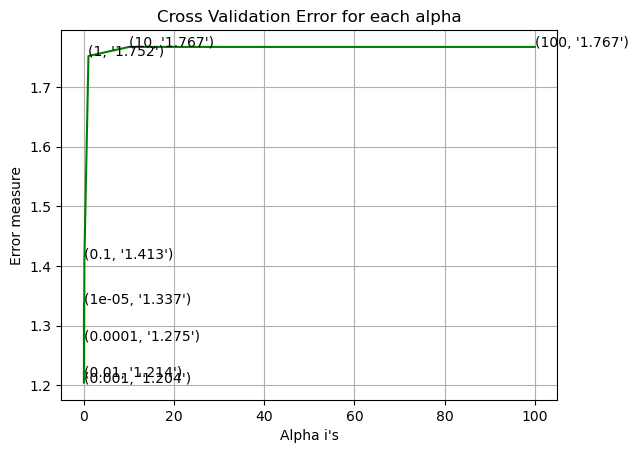

For values of best alpha =  0.001 The train log loss is: 0.5303016507267594
For values of best alpha =  0.001 The cross validation log loss is: 1.2040962367052792
For values of best alpha =  0.001 The test log loss is: 1.1855982934509306


In [157]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

### 测试最优超参数alpha

Log loss : 1.2040962367052792
Number of mis-classified points : 0.37218045112781956
-------------------- Confusion matrix --------------------


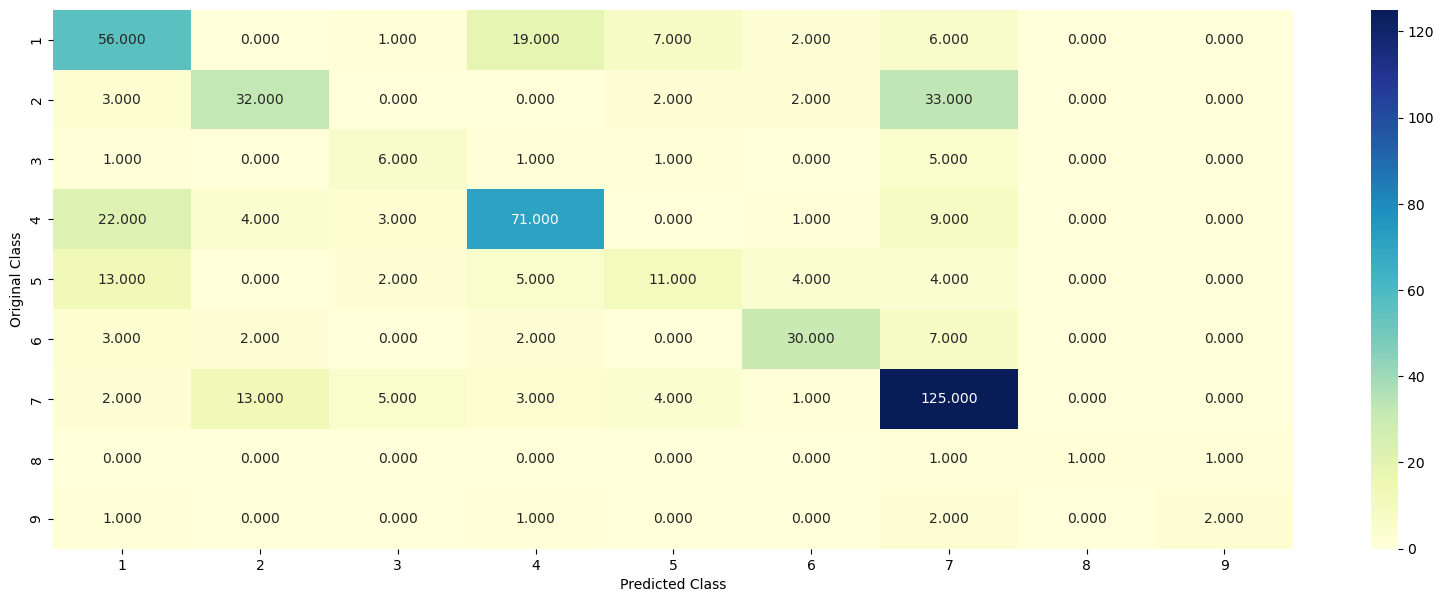

-------------------- Precision matrix (Columm Sum=1) --------------------


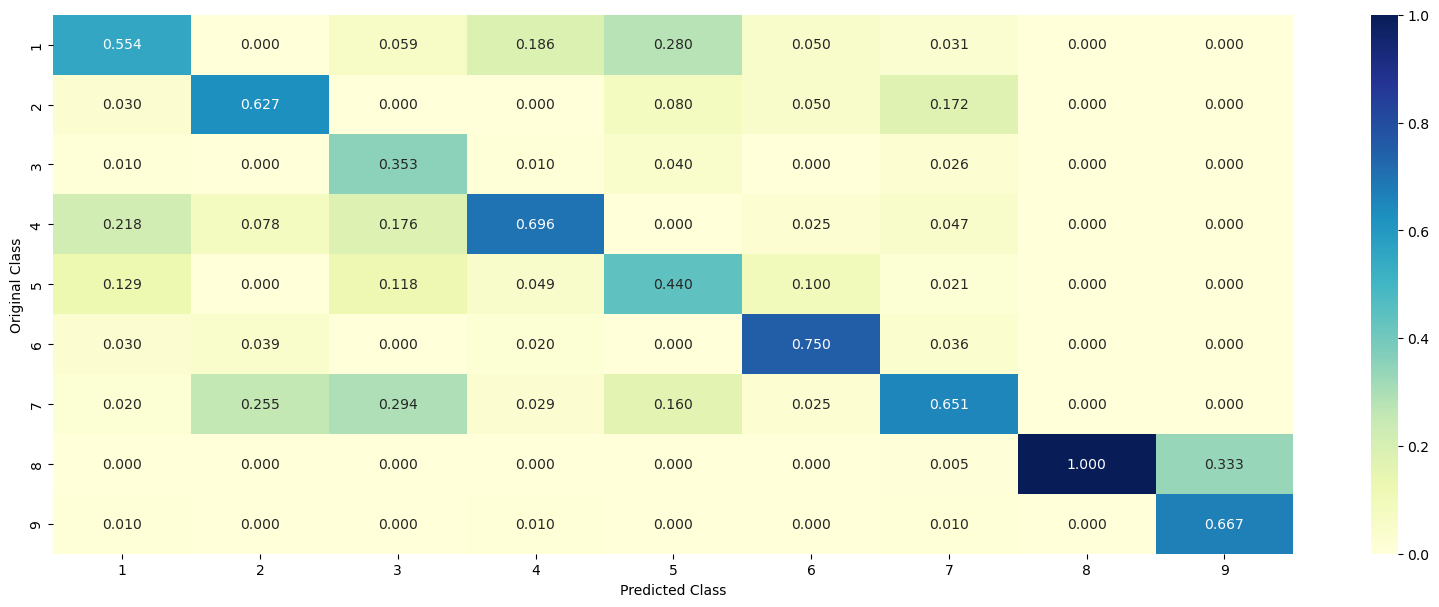

-------------------- Recall matrix (Row sum=1) --------------------


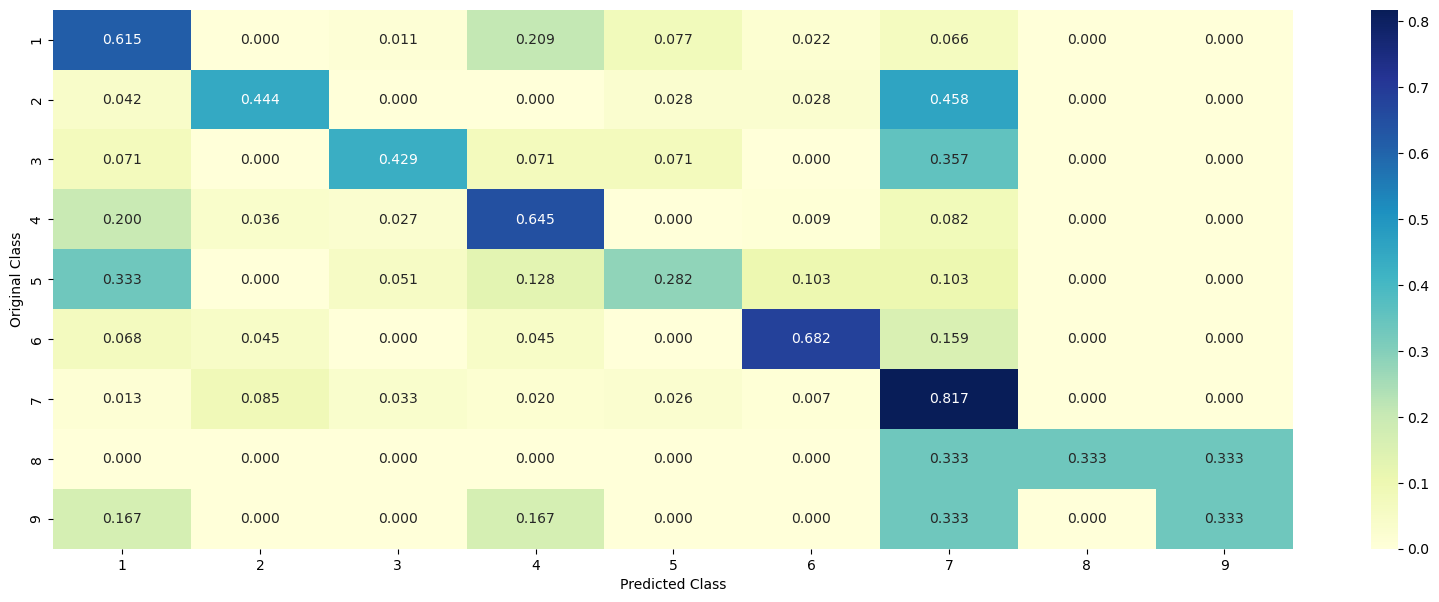

In [158]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### 查询点和解释性
查询一些被正确分类的样本

In [159]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0297 0.5768 0.0017 0.0284 0.0081 0.0336 0.3142 0.0034 0.0039]]
Actual Class : 2
--------------------------------------------------
165 Text feature [costello] present in test data point [True]
175 Text feature [pyrosequencing] present in test data point [True]
212 Text feature [discretion] present in test data point [True]
247 Text feature [micropapillary] present in test data point [True]
307 Text feature [demographic] present in test data point [True]
333 Text feature [houben] present in test data point [True]
342 Text feature [mo] present in test data point [True]
345 Text feature [flaherty] present in test data point [True]
348 Text feature [corporation] present in test data point [True]
353 Text feature [chemoradiotherapy] present in test data point [True]
366 Text feature [g466] present in test data point [True]
372 Text feature [g466v] present in test data point [True]
373 Text feature [d594n] present in test data point [Tru

## 随机森林分类

### 采用独热编码的模型

In [160]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.2738604078938227
for n_estimators = 100 and max depth =  10
Log Loss : 1.2024892437666772
for n_estimators = 200 and max depth =  5
Log Loss : 1.2738384466095416
for n_estimators = 200 and max depth =  10
Log Loss : 1.1893460183025377
for n_estimators = 500 and max depth =  5
Log Loss : 1.2619735295240364
for n_estimators = 500 and max depth =  10
Log Loss : 1.189884992402138
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2590880930471378
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1893186765978332
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2580894642405243
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1881145767446255


In [161]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best estimator =  2000 The train log loss is: 0.6911769949069456
For values of best estimator =  2000 The cross validation log loss is: 1.1881145767446255
For values of best estimator =  2000 The test log loss is: 1.160620366619315


下面测试最优超参

Log loss : 1.1881145767446255
Number of mis-classified points : 0.39473684210526316
-------------------- Confusion matrix --------------------


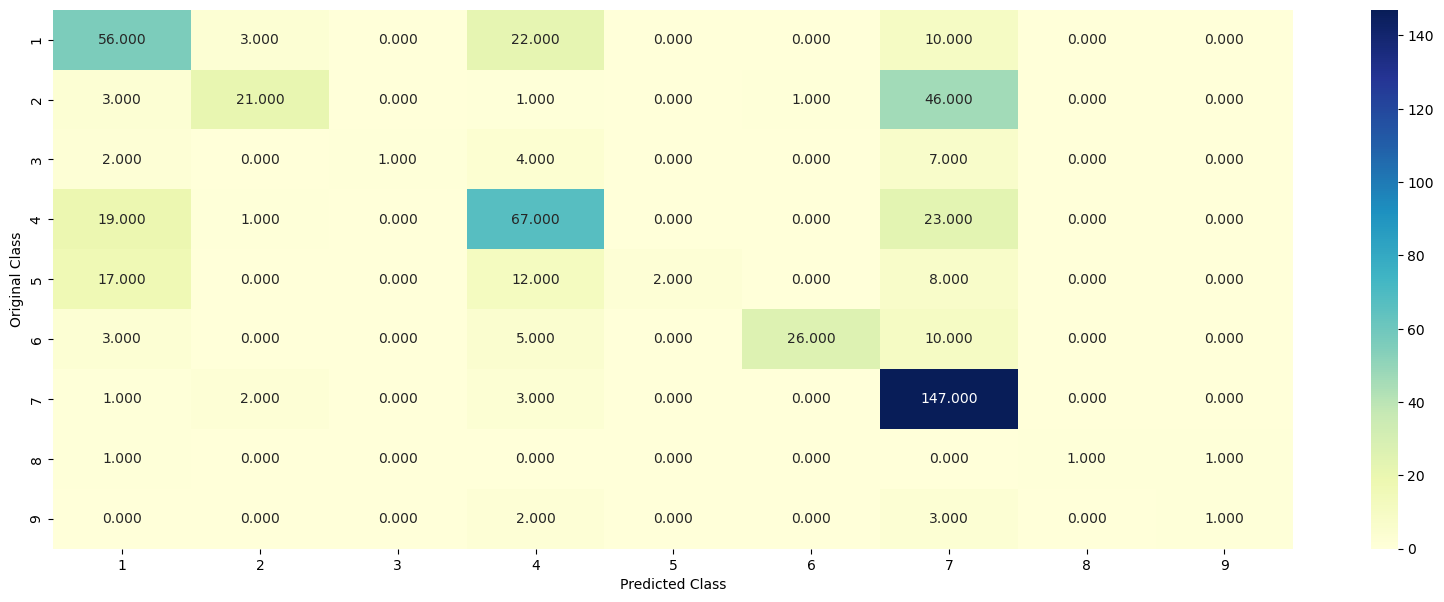

-------------------- Precision matrix (Columm Sum=1) --------------------


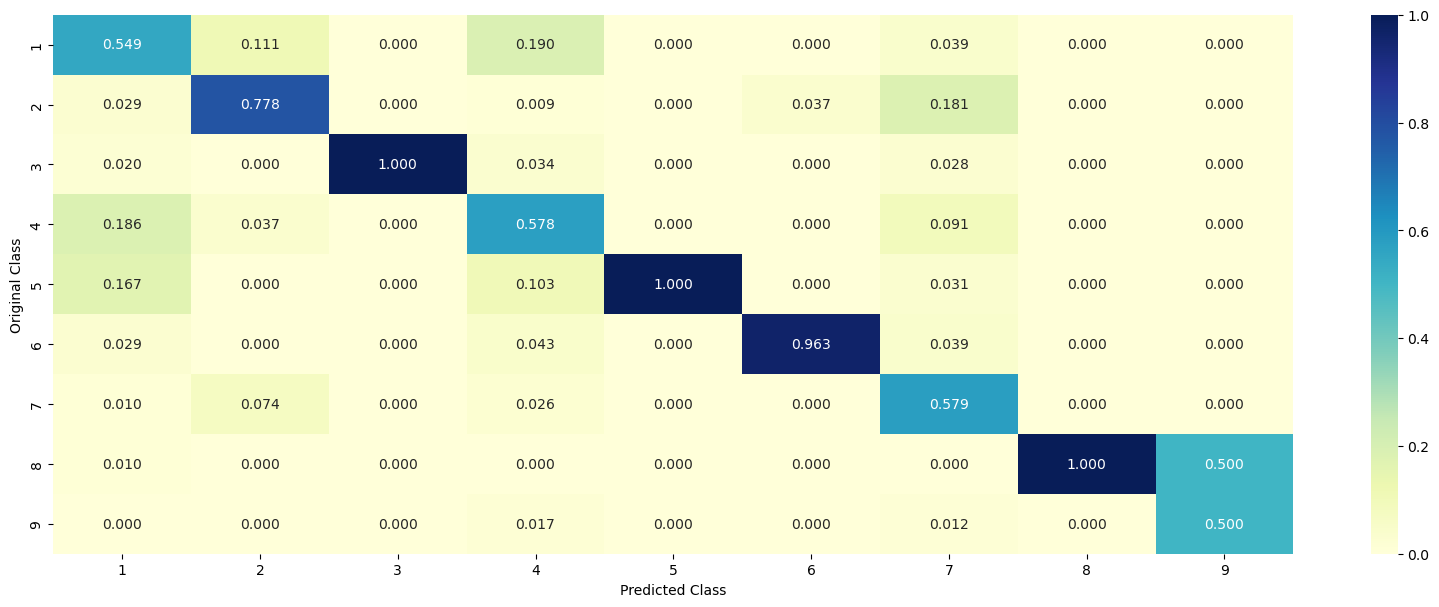

-------------------- Recall matrix (Row sum=1) --------------------


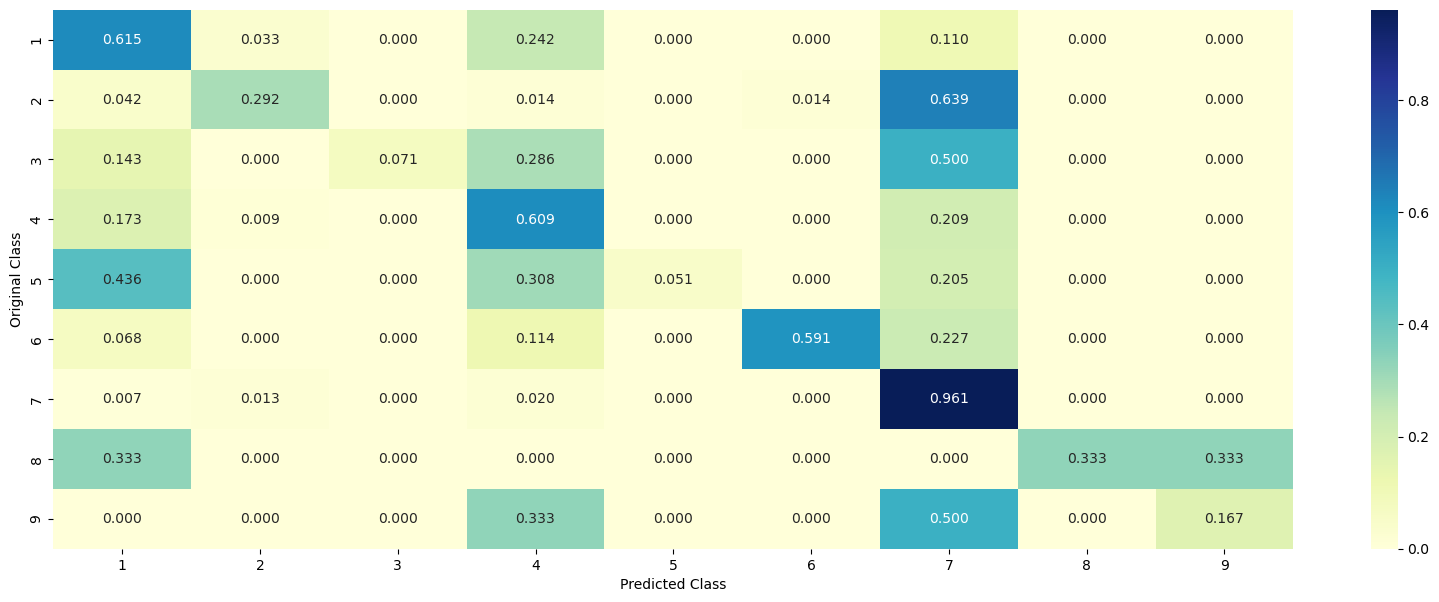

In [162]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [163]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0326 0.2521 0.0122 0.0264 0.0335 0.0252 0.6108 0.0032 0.0039]]
Actual Class : 2
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [activation] present in test data point [True]
3 Text feature [treatment] present in test data point [True]
4 Text feature [activated] present in test data point [True]
5 Text feature [tyrosine] present in test data point [True]
6 Text feature [constitutive] present in test data point [True]
7 Text feature [inhibitors] present in test data point [True]
8 Text feature [missense] present in test data point [True]
9 Text feature [inhibitor] present in test data point [True]
10 Text feature [phosphorylation] present in test data point [True]
11 Text feature [signaling] present in test data point [True]
13 Text feature [function] present in test data point [True]
14 Text feat

### 采用响应编码的随机森林分类器

In [127]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.12180030037
for n_estimators = 10 and max depth =  3
Log Loss : 1.7404838211
for n_estimators = 10 and max depth =  5
Log Loss : 1.45956634309
for n_estimators = 10 and max depth =  10
Log Loss : 1.81334477685
for n_estimators = 50 and max depth =  2
Log Loss : 1.68074797837
for n_estimators = 50 and max depth =  3
Log Loss : 1.42491182941
for n_estimators = 50 and max depth =  5
Log Loss : 1.3152461495
for n_estimators = 50 and max depth =  10
Log Loss : 1.70612841413
for n_estimators = 100 and max depth =  2
Log Loss : 1.514016191
for n_estimators = 100 and max depth =  3
Log Loss : 1.43821890163
for n_estimators = 100 and max depth =  5
Log Loss : 1.28392384765
for n_estimators = 100 and max depth =  10
Log Loss : 1.67237216443
for n_estimators = 200 and max depth =  2
Log Loss : 1.53734403774
for n_estimators = 200 and max depth =  3
Log Loss : 1.44171291375
for n_estimators = 200 and max depth =  5
Log Loss : 1.35300190057
for 

测试最优超参

Log loss : 1.28392384765
Number of mis-classified points : 0.4868421052631579
-------------------- Confusion matrix --------------------


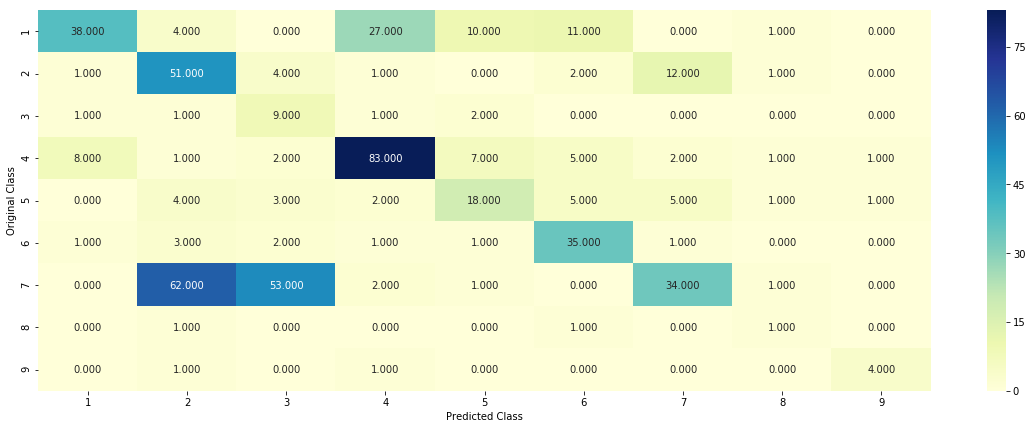

-------------------- Precision matrix (Columm Sum=1) --------------------


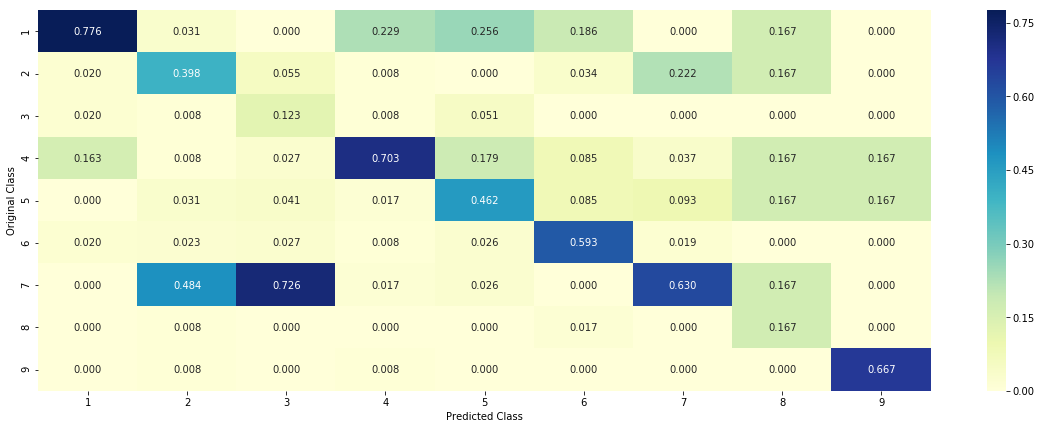

-------------------- Recall matrix (Row sum=1) --------------------


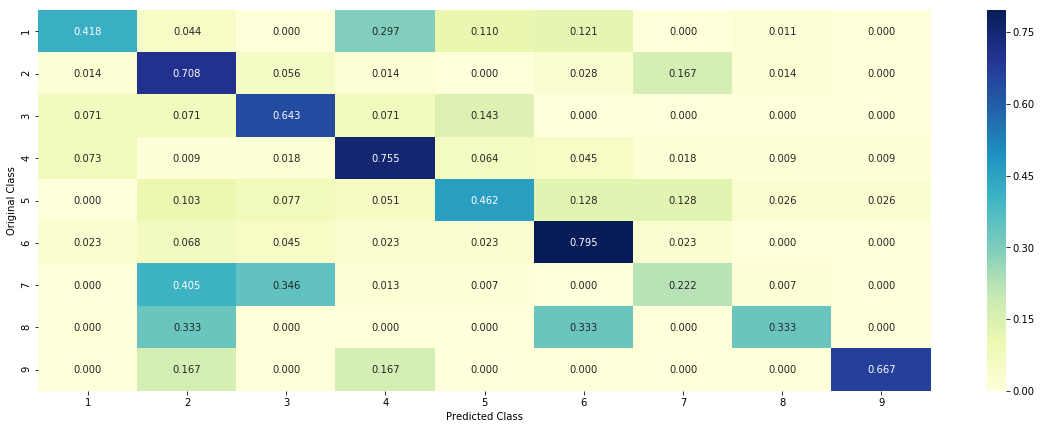

In [128]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

### 查询点和解释性
查询正确分类的样本

In [129]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[  2.00000000e-03   2.44000000e-02   1.70000000e-03   3.00000000e-03
    9.00000000e-04   3.10000000e-03   9.61800000e-01   1.40000000e-03
    1.70000000e-03]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature

## 堆叠模型

### 什么是堆叠模型？ 
**Stacking 的原理：**\
Stacking（堆叠）是一种**集成学习方法**，通过结合多个*基模型*（base models）的预测结果来构建一个*元模型*（meta model）。其核心思想是利用基模型的**预测结果**作为**输入**，训练一个更高层次的模型（元模型）来做出最终预测。

**Stacking 的工作流程**
1. 训练基模型：使用训练数据训练多个基模型（例如，逻辑回归、决策树、支持向量机等）。
2. 生成基模型的预测结果：对训练数据和验证数据分别使用基模型进行预测，得到预测结果（概率值或类别标签）。
3. 构建元模型：将基模型的预测结果作为新的特征，训练一个元模型（例如，逻辑回归、线性回归等）。
4. 最终预测：使用元模型对测试数据进行最终预测。


**Stacking 模型的性能**

**优点**
1. 捕捉多样性：不同的基模型可能捕捉到数据的不同特征，通过结合它们的预测结果，可以提高模型的泛化能力。
2. 减少偏差和方差：基模型的偏差和方差可能不同，通过堆叠可以减少整体模型的偏差和方差。
3. 元模型的优化：元模型可以通过学习基模型的预测结果之间的关系，进一步优化最终预测。

**缺点**
1. 过拟合风险：如果基模型在训练数据上过拟合，可能会导致元模型也过拟合。
2. 计算成本高：训练多个基模型和元模型需要更多的计算资源和时间。
3. 复杂性问题：堆叠模型的复杂性较高，可能难以解释和调试。


In [164]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.17
Support vector machines : Log Loss: 1.75
Naive Bayes : Log Loss: 1.38
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.729
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.368
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.257
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.557
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.898


测试最优超参

Log loss (train) on the stacking classifier : 0.48358109314059455
Log loss (CV) on the stacking classifier : 1.2569519666642288
Log loss (test) on the stacking classifier : 1.1604530408214326
Number of missclassified point : 0.3774436090225564
-------------------- Confusion matrix --------------------


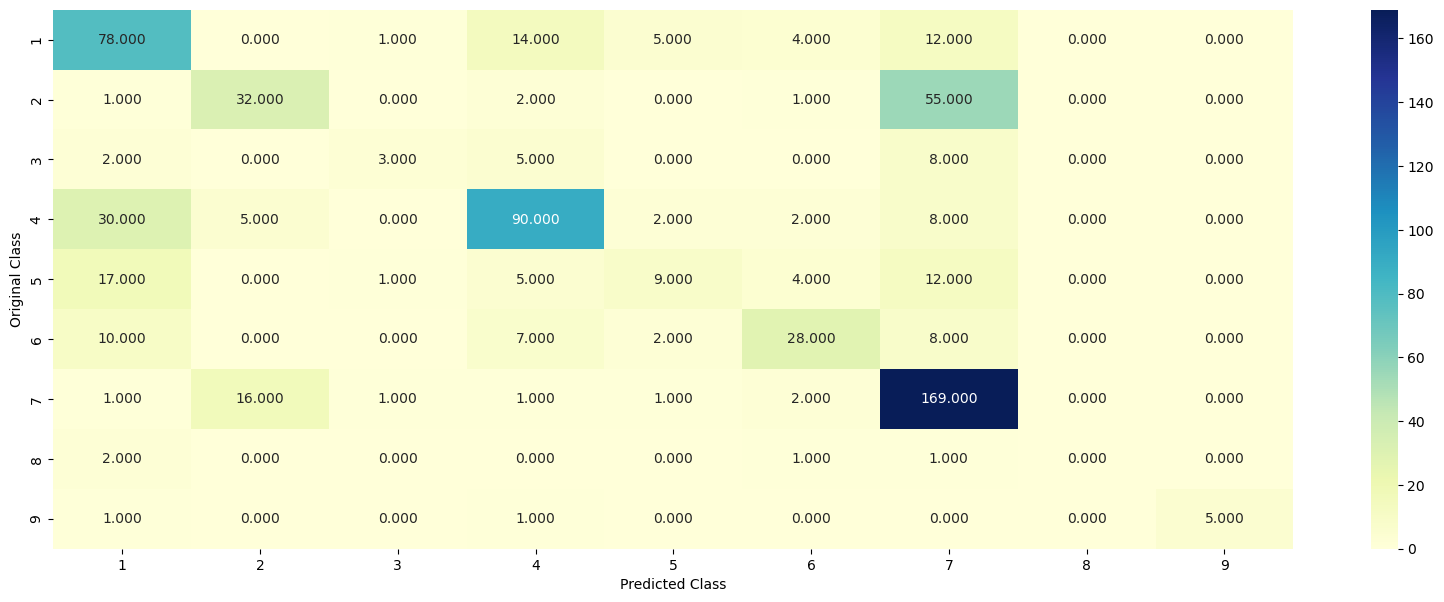

-------------------- Precision matrix (Columm Sum=1) --------------------


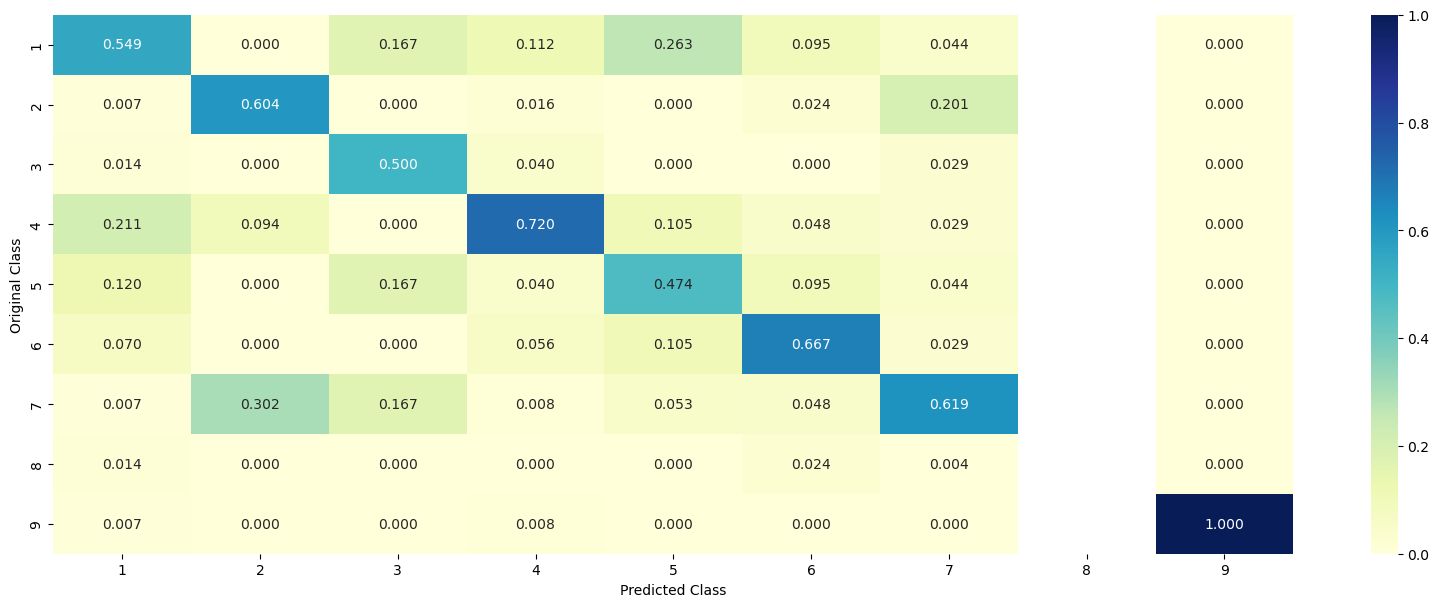

-------------------- Recall matrix (Row sum=1) --------------------


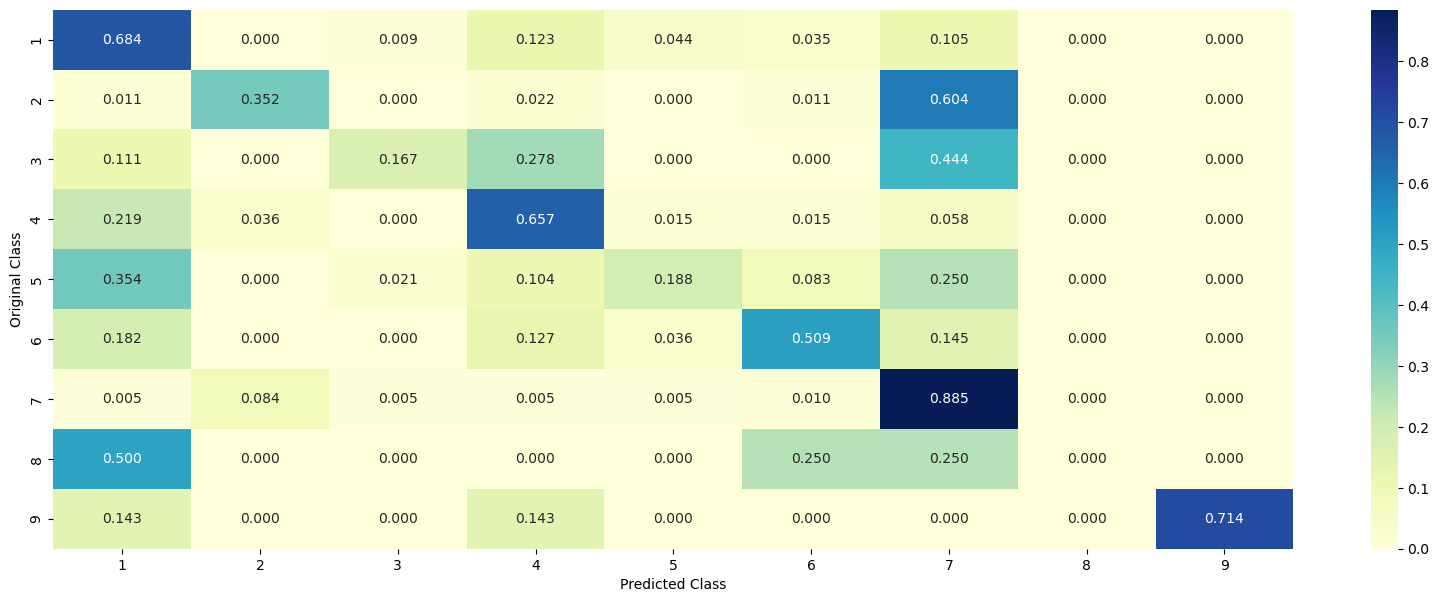

In [165]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## 最大投票分类器（Maximum Voting Classifier）


### 什么是最大投票分类器？

**最大投票分类器** 是一种集成学习方法，通过结合多个基分类器的预测结果来进行最终决策。核心思想是“少数服从多数”，即选择大多数分类器支持的**类别**作为最终预测结果。

**工作原理**
1. 训练多个基分类器：\
    使用不同的分类算法（如逻辑回归、决策树、支持向量机等）训练多个基分类器。
2. 对每个样本进行预测：\
    对于测试集中的每个样本，每个基分类器都会给出一个预测结果。
3. 投票决定最终结果：
    对于分类问题，选择得票最多的类别作为最终预测结果。
    对于回归问题，可以采用平均值或加权平均值。\
**示例**
假设我们有 3 个基分类器，对某个样本的预测结果如下：

分类器 1：类别 A \
分类器 2：类别 B\
分类器 3：类别 A\
根据最大投票原则，最终预测结果为 类别 A。

**优点**
1. 简单易实现。
2. 通过结合多个分类器的预测结果，可以提高模型的泛化能力和鲁棒性。
3. 适用于多种分类任务。

**缺点**
1. 如果基分类器的性能差异较大，可能会受到低性能分类器的影响。
2. 需要训练多个分类器，计算成本较高。

**应用场景**
1. 当单一分类器的性能有限时，可以通过集成多个分类器来提高预测准确性。
2. 适用于分类任务，尤其是在类别分布均衡的情况下。

Log loss (train) on the VotingClassifier : 0.8506109250079006
Log loss (CV) on the VotingClassifier : 1.2610110481212358
Log loss (test) on the VotingClassifier : 1.2059221155800646
Number of missclassified point : 0.3849624060150376
-------------------- Confusion matrix --------------------


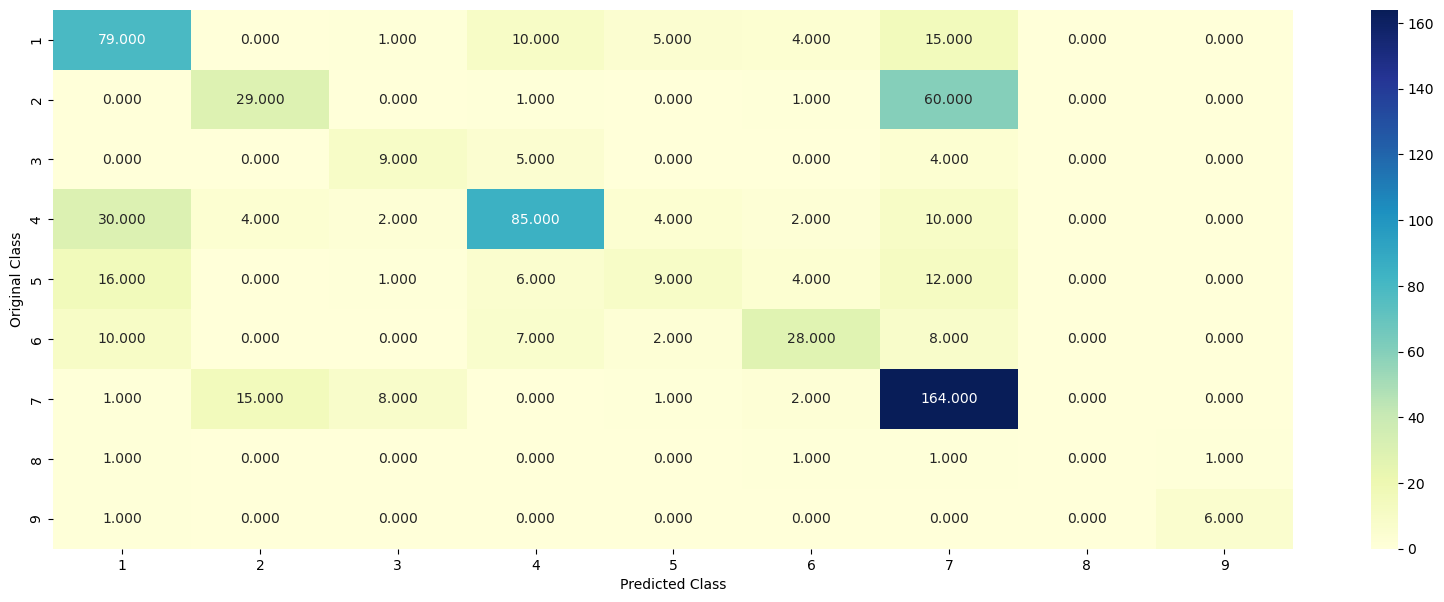

-------------------- Precision matrix (Columm Sum=1) --------------------


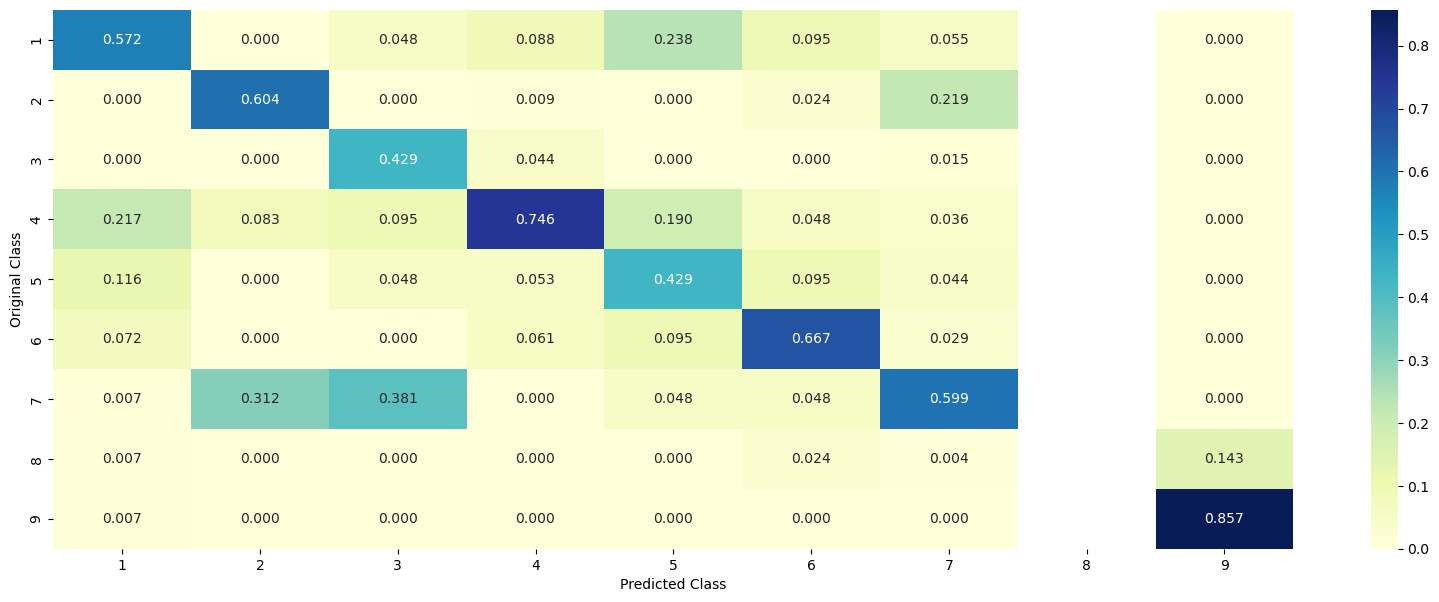

-------------------- Recall matrix (Row sum=1) --------------------


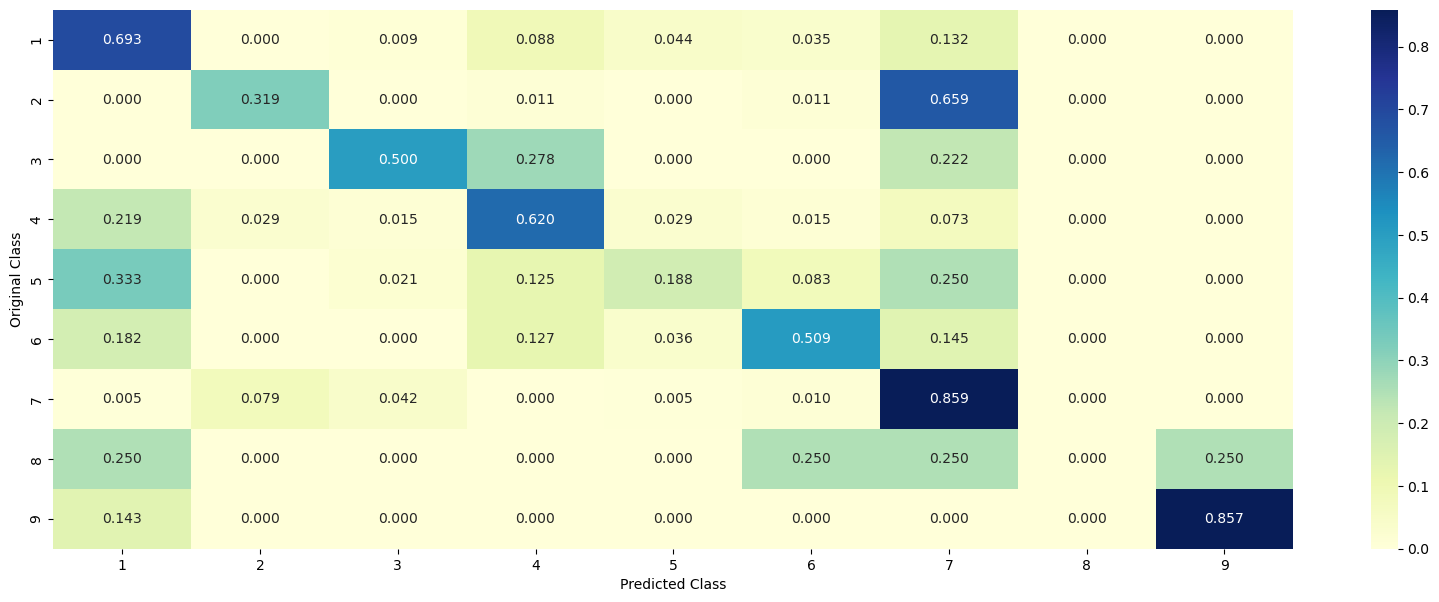

In [166]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))